In [1]:
import scanpy as sc
from anndata import AnnData

from grnndata import GRNAnnData, from_embeddings
from grnndata import utils 

from scdataloader import Preprocessor as myPreprocessor
from bengrn import BenGRN, get_sroy_gt, get_perturb_gt

import os
import warnings
import sys
import numpy as np

sys.path.insert(0, "../")
from scgpt_helper import prepare_model, prepare_dataset, generate_embedding, generate_grn
import scgpt as scg
from scgpt.tasks import GeneEmbedding
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.utils import set_seed
from scgpt.tokenizer import tokenize_and_pad_batch
import torch


os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

print(torch.cuda.is_available())
set_seed(42)


💡 connected lamindb: jkobject/scprint


2024-05-28 22:29:20,959:INFO - Created a temporary directory at /tmp/tmpvrnzk6g0
2024-05-28 22:29:20,961:INFO - Writing /tmp/tmpvrnzk6g0/_remote_module_non_scriptable.py
/home/ml4ig1/Documents code/scGPT/mytests/../scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/home/ml4ig1/Documents code/scGPT/mytests/../scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
2024-05-28 22:29:21,330:INFO - PyTorch version 2.1.2 available.
2024-05-28 22:29:21,333:INFO - JAX version 0.4.23 available.


True



## Step 1: Load fine-tuned model and dataset


### 1.1 Load fine-tuned model

We are going to load a fine-tuned model for the gene interaction analysis on
Adamson dataset. The fine-tuned model can be downloaded via this
[link](https://drive.google.com/drive/folders/1HsPrwYGPXm867_u_Ye0W4Ch8AFSneXAn).
The dataset will be loaded in the next step 1.2.

To reproduce the provided fine-tuned model. Please followw the integration
fin-tuning pipeline to fine-tune the pre-trained blood model on the Adamson
perturbation dataset. Note that in the fine-tuning stage, we did not perform
highly vairable gene selection but trained on the 5000+ genes present in the
Adamson dataset. This is to provide flexbility in the inference stage to
investigate changes in attention maps across different perturbation conditions.


In [2]:
model, vocab = prepare_model(model_dir="../save/scGPT_human")

Resume model from ../save/scGPT_human/best_model.pt, the model args will override the config ../save/scGPT_human/args.json.



In [25]:
model

TransformerModel(
  (encoder): GeneEncoder(
    (embedding): Embedding(60697, 512, padding_idx=60694)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (value_encoder): ContinuousValueEncoder(
    (dropout): Dropout(p=0.5, inplace=False)
    (linear1): Linear(in_features=1, out_features=512, bias=True)
    (activation): ReLU()
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-11): 12 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.5, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, el

In [3]:
mpreprocessor = myPreprocessor(is_symbol=True, force_preprocess=True, skip_validate=True,
                            do_postp=False, min_valid_genes_id=5000, min_dataset_size=64)

NUM_GENES = 5000
genes = torch.load('../../scPRINT/data/temp/vbd8bavn/epoch=17-step=90000.ckpt')['hyper_parameters']['genes']

In [4]:
preadata = get_sroy_gt(get="liu", species="human", gt="full")
adata = mpreprocessor(preadata.copy())


KeyboardInterrupt: 

In [ ]:
sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", n_top_genes=NUM_GENES)
adata.var['ensembl_id'] = adata.var.index
subadata = adata[:1024, adata.var.index.isin(
    genes) & adata.var.highly_variable]
subadata.var = subadata.var.set_index("symbol")

In [14]:
grn = generate_grn(model, vocab, subadata, batch_size = 10, num_attn_layers = 11)

scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Log1p transforming ...
scGPT - INFO - Binning data ...


100%|██████████| 8/8 [00:06<00:00,  1.22it/s]


base enrichment
Top central genes: []


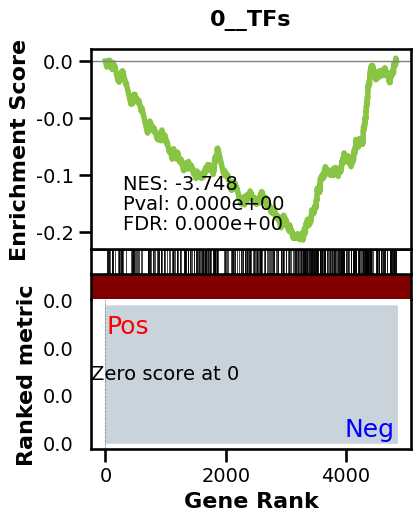

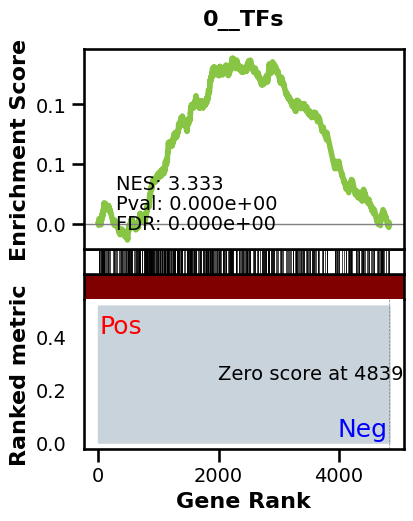

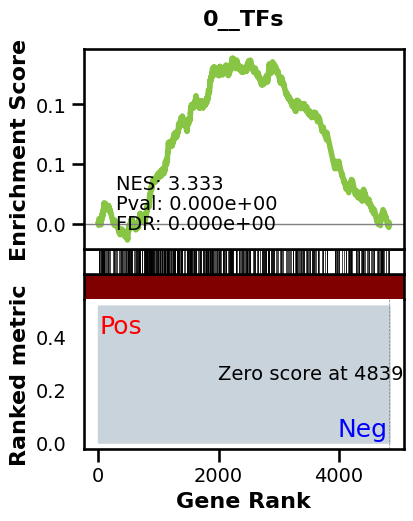

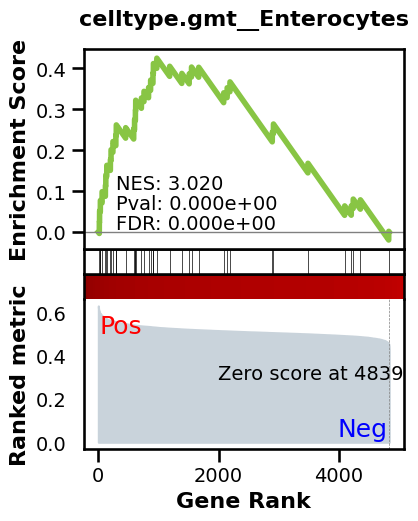

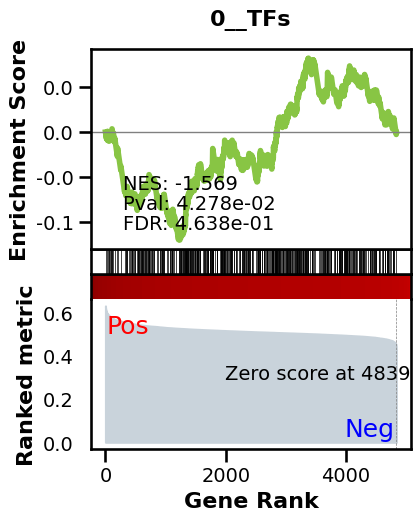

_________________________________________
TF specific enrichment


2024-05-27 13:05:21,890:INFO - Downloading and generating Enrichr library gene sets...
2024-05-27 13:05:21,892:INFO - Library is already downloaded in: /home/ml4ig1/.cache/gseapy/Enrichr.ENCODE_TF_ChIP-seq_2014.gmt, use local file
2024-05-27 13:05:22,105:INFO - 0332 gene_sets have been filtered out when max_size=2000 and min_size=0


found some significant results for  4.25531914893617 % TFs

_________________________________________
loading GT,  omnipath
intersection of 3314 genes
intersection pct: 0.6847107438016529
precision:  0.001067325065949799 
recall:  1.0 
random precision: 0.0010676472286621293


100%|██████████| 99/99 [00:01<00:00, 58.90it/s]


Area Under Precision-Recall Curve (AUPRC):  0.0013608850913376866
EPR: 1.1990746425516294


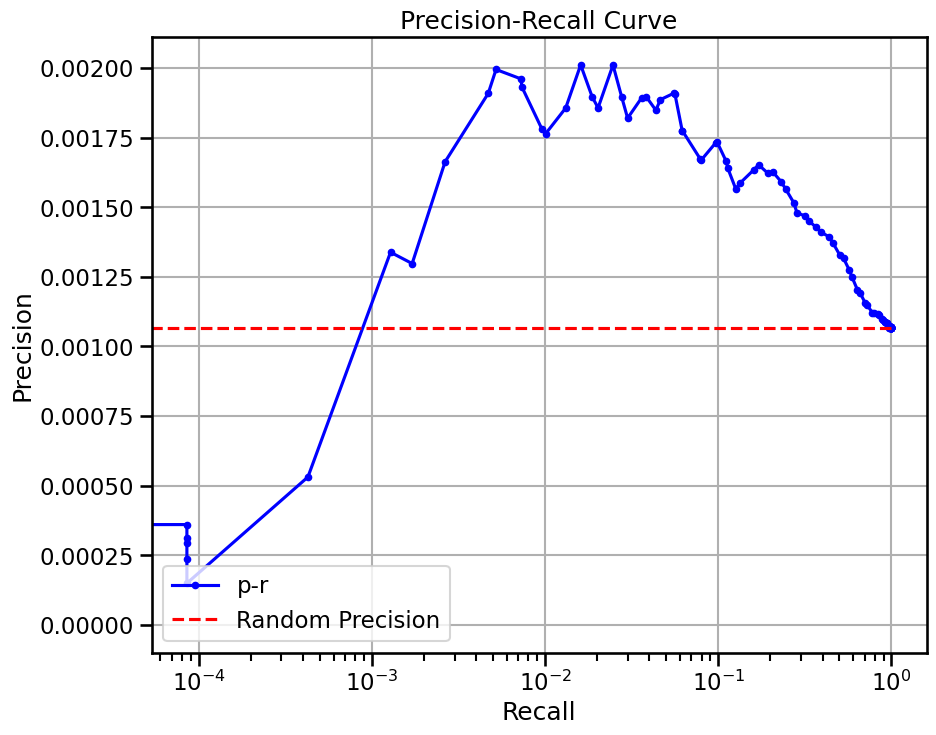

{'TF_enr': True,
 'enriched_terms_Targets': ['0__TFs',
  'celltype.gmt__Cholangiocytes',
  'celltype.gmt__Endothelial',
  'celltype.gmt__Parietal cells',
  'celltype.gmt__Airway goblet cells'],
 'enriched_terms_Regulators': ['celltype.gmt__Enterocytes',
  'celltype.gmt__Hepatocytes',
  'celltype.gmt__Cholangiocytes',
  'celltype.gmt__Clara cells',
  'celltype.gmt__Ductal cells',
  'celltype.gmt__Merkel cells',
  'celltype.gmt__Progenitor cells',
  'celltype.gmt__Foveolar cells',
  'celltype.gmt__Mesangial cells',
  'celltype.gmt__Hepatic stellate cells',
  'celltype.gmt__HSC/MPP cells',
  'celltype.gmt__Myofibroblasts',
  'celltype.gmt__Fibroblasts',
  'celltype.gmt__Granulocytes',
  'celltype.gmt__Pancreatic stellate cells',
  'celltype.gmt__Principal cells (Collecting duct system)',
  'celltype.gmt__Pancreatic progenitor cells',
  'celltype.gmt__Satellite cells',
  'celltype.gmt__Basophils',
  'celltype.gmt__Keratinocytes',
  'celltype.gmt__Immune system cells',
  'celltype.gmt__Peri

In [20]:
BenGRN(grn, do_auc=True, doplot=True).scprint_benchmark()

precision:  0.03667355371900827 
recall:  0.9978917779339423 
random precision: 0.030954633950033172


100%|██████████| 99/99 [00:00<00:00, 2145.25it/s]


Area Under Precision-Recall Curve (AUPRC):  0.045360037950428825
EPR: 2.3703234637259643


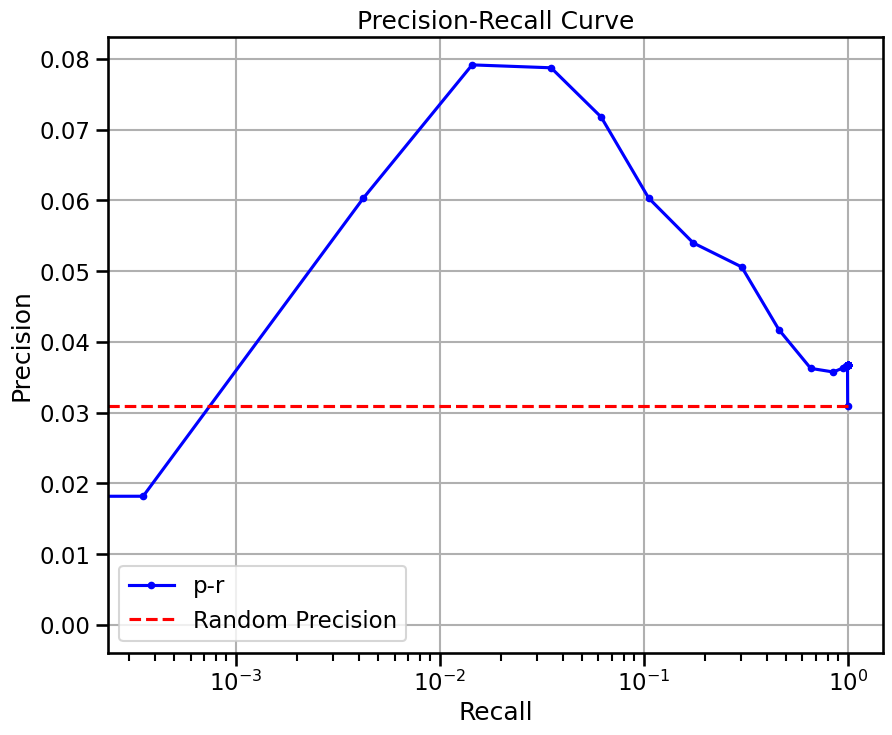

{'precision': 0.03667355371900827,
 'recall': 0.9978917779339423,
 'rand_precision': 0.030954633950033172,
 'auprc': 0.045360037950428825,
 'EPR': 2.3703234637259643}

In [132]:
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

## liu chip

In [148]:
preadata = get_sroy_gt(get="liu", species="human", gt="chip")
adata = mpreprocessor(preadata.copy())

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
 KeysView(Layers with keys: )
checking raw counts
Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess
removed 0 non primary cells, 72 renamining
filtered out 0 cells, 72 renamining
Removed 0 genes.
startin QC
Seeing 4 outliers (5.56% of total dataset):
done


In [149]:
sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", n_top_genes=NUM_GENES)
adata.var['ensembl_id'] = adata.var.index
subadata = adata[:1024, adata.var.index.isin(
    genes) & adata.var.highly_variable]
subadata.var = subadata.var.set_index("symbol")

In [150]:
all_gene_ids, all_values, src_key_padding_mask, subadata = prepare_dataset(subadata)
sum_attn_scores = generate_grn(model, all_gene_ids, all_values, src_key_padding_mask, batch_size = 10, num_attn_layers = 11)
grn = GRNAnnData(subadata, grn=sum_attn_scores[1:,1:])

scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Log1p transforming ...
scGPT - INFO - Binning data ...


  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:06<00:00,  1.18it/s]


precision:  0.27871255165289255 
recall:  1.0 
random precision: 0.27877014879107254


100%|██████████| 99/99 [00:00<00:00, 660.77it/s]


Area Under Precision-Recall Curve (AUPRC):  0.31230339581416194
EPR: 1.2961706552423633


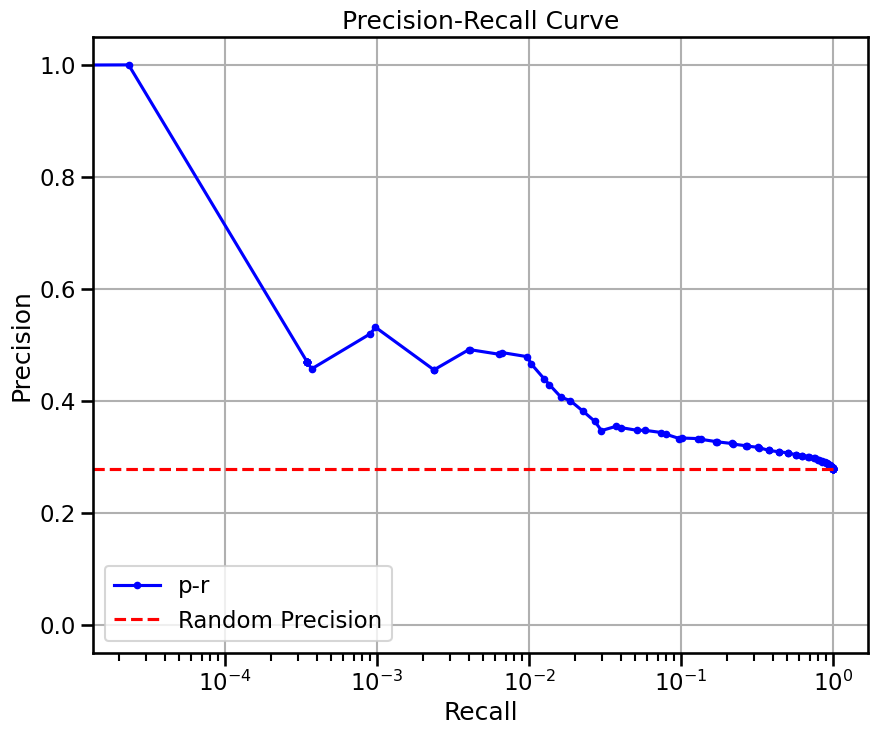

{'precision': 0.27871255165289255,
 'recall': 1.0,
 'rand_precision': 0.27877014879107254,
 'auprc': 0.31230339581416194,
 'EPR': 1.2961706552423633}

In [151]:
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

## KO LIU

In [152]:
preadata = get_sroy_gt(get="liu", species="human", gt="ko")
adata = mpreprocessor(preadata.copy())

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
 KeysView(Layers with keys: )
checking raw counts
Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess
removed 0 non primary cells, 72 renamining
filtered out 0 cells, 72 renamining
Removed 0 genes.
startin QC
Seeing 4 outliers (5.56% of total dataset):
done


In [153]:
sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", n_top_genes=NUM_GENES)
adata.var['ensembl_id'] = adata.var.index
subadata = adata[:1024, adata.var.index.isin(
    genes) & adata.var.highly_variable]
subadata.var = subadata.var.set_index("symbol")

In [154]:
all_gene_ids, all_values, src_key_padding_mask, subadata = prepare_dataset(subadata)
sum_attn_scores = generate_grn(model, all_gene_ids, all_values, src_key_padding_mask, batch_size = 10, num_attn_layers = 11)
grn = GRNAnnData(subadata, grn=sum_attn_scores[1:,1:])

scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Log1p transforming ...
scGPT - INFO - Binning data ...


 12%|█▎        | 1/8 [00:01<00:08,  1.22s/it]

100%|██████████| 8/8 [00:06<00:00,  1.18it/s]


precision:  0.056736789381417484 
recall:  1.0 
random precision: 0.056748514281062326


100%|██████████| 99/99 [00:00<00:00, 711.55it/s]


Area Under Precision-Recall Curve (AUPRC):  0.056651319332588164
EPR: 1.166255906721511


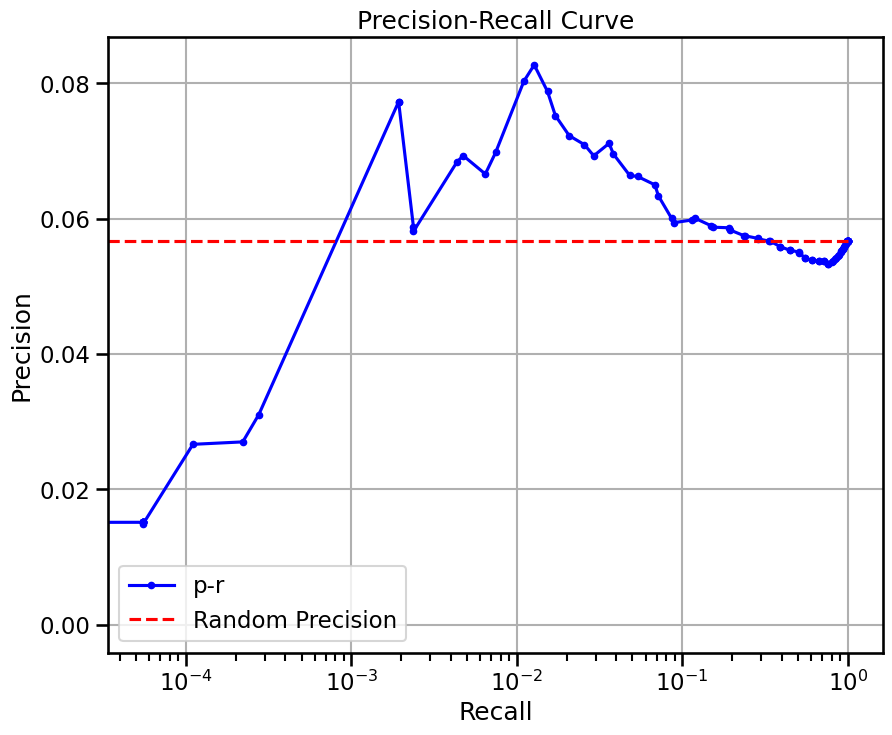

{'precision': 0.056736789381417484,
 'recall': 1.0,
 'rand_precision': 0.056748514281062326,
 'auprc': 0.056651319332588164,
 'EPR': 1.166255906721511}

In [155]:
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

## full CHEN

In [156]:
preadata = get_sroy_gt(get="chen", species="human", gt="full")
adata = mpreprocessor(preadata.copy())

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
 KeysView(Layers with keys: )
checking raw counts
Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess
removed 0 non primary cells, 385 renamining
filtered out 0 cells, 385 renamining
Removed 0 genes.
startin QC
Seeing 38 outliers (9.87% of total dataset):
done


In [157]:
sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", n_top_genes=NUM_GENES)
adata.var['ensembl_id'] = adata.var.index
subadata = adata[:1024, adata.var.index.isin(
    genes) & adata.var.highly_variable]
subadata.var = subadata.var.set_index("symbol")

In [158]:
all_gene_ids, all_values, src_key_padding_mask, subadata = prepare_dataset(subadata)
sum_attn_scores = generate_grn(model, all_gene_ids, all_values, src_key_padding_mask, batch_size = 10, num_attn_layers = 11)
grn = GRNAnnData(subadata, grn=sum_attn_scores[1:,1:])

scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Log1p transforming ...
scGPT - INFO - Binning data ...


  0%|          | 0/39 [00:00<?, ?it/s]

100%|██████████| 39/39 [00:32<00:00,  1.20it/s]


precision:  0.01741452589611464 
recall:  1.0 
random precision: 0.017418129149972726


100%|██████████| 99/99 [00:00<00:00, 5129.41it/s]


Area Under Precision-Recall Curve (AUPRC):  0.020255716694338767
EPR: 1.7150758289088976


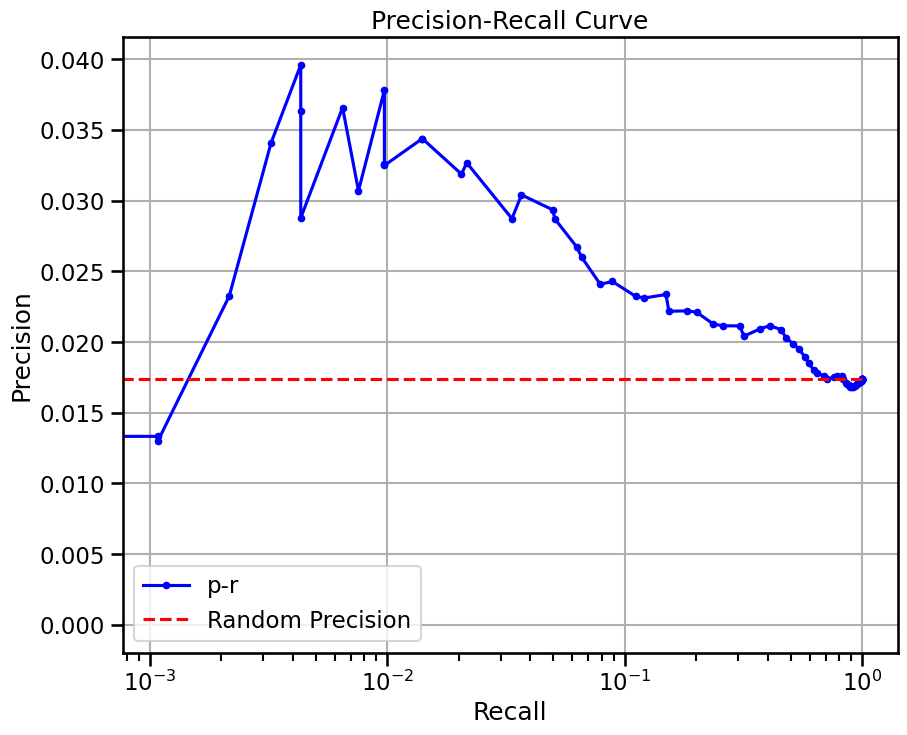

{'precision': 0.01741452589611464,
 'recall': 1.0,
 'rand_precision': 0.017418129149972726,
 'auprc': 0.020255716694338767,
 'EPR': 1.7150758289088976}

In [159]:
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

## CHEN chip

In [5]:
preadata = get_sroy_gt(get="chen", species="human", gt="chip")
adata = mpreprocessor(preadata.copy())

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
 KeysView(Layers with keys: )
checking raw counts
Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess
removed 0 non primary cells, 385 renamining
filtered out 0 cells, 385 renamining
Removed 0 genes.
startin QC
Seeing 38 outliers (9.87% of total dataset):
done


In [6]:
sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", n_top_genes=NUM_GENES)
adata.var['ensembl_id'] = adata.var.index
subadata = adata[:1024, adata.var.index.isin(
    genes) & adata.var.highly_variable]
subadata.var = subadata.var.set_index("symbol")

In [7]:
grn = generate_grn(model, vocab, subadata, batch_size = 9, num_attn_layers = 11)

scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Log1p transforming ...
scGPT - INFO - Binning data ...


100%|██████████| 43/43 [00:33<00:00,  1.27it/s]


precision:  0.33784305613018895 
recall:  1.0 
random precision: 0.3379129595144493


100%|██████████| 99/99 [00:00<00:00, 660.63it/s]


Area Under Precision-Recall Curve (AUPRC):  0.3215175188010664
EPR: 0.8770907111516801


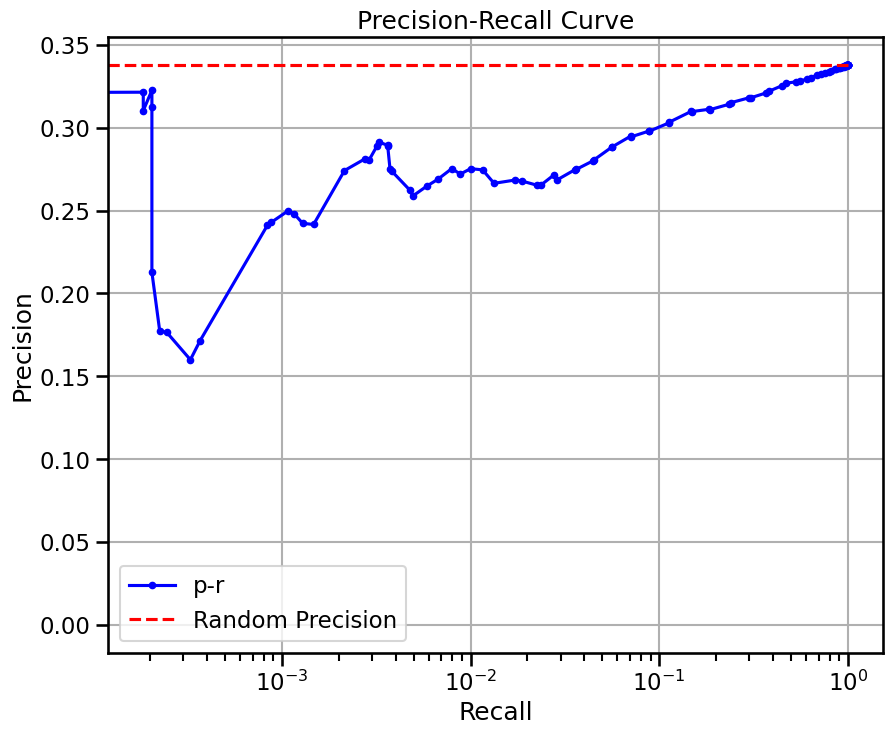

{'precision': 0.33784305613018895,
 'recall': 1.0,
 'rand_precision': 0.3379129595144493,
 'auprc': 0.3215175188010664,
 'epr': 0.8770907111516801}

In [8]:
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

## full CHEN

In [9]:
preadata = get_sroy_gt(get="chen", species="human", gt="full")
adata = mpreprocessor(preadata.copy())

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
 KeysView(Layers with keys: )
checking raw counts
Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess
removed 0 non primary cells, 385 renamining
filtered out 0 cells, 385 renamining
Removed 0 genes.
startin QC
Seeing 38 outliers (9.87% of total dataset):
done


In [10]:
sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", n_top_genes=NUM_GENES)
adata.var['ensembl_id'] = adata.var.index
subadata = adata[:1024, adata.var.index.isin(
    genes) & adata.var.highly_variable]
subadata.var = subadata.var.set_index("symbol")

In [12]:
grn = generate_grn(model, vocab, subadata, batch_size = 9, num_attn_layers = 11)

scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Log1p transforming ...
scGPT - INFO - Binning data ...


100%|██████████| 43/43 [00:33<00:00,  1.27it/s]


precision:  0.01741452589611464 
recall:  1.0 
random precision: 0.017418129149972726


100%|██████████| 99/99 [00:00<00:00, 2648.12it/s]


Area Under Precision-Recall Curve (AUPRC):  0.025751919062668955
EPR: 2.4745125192760327


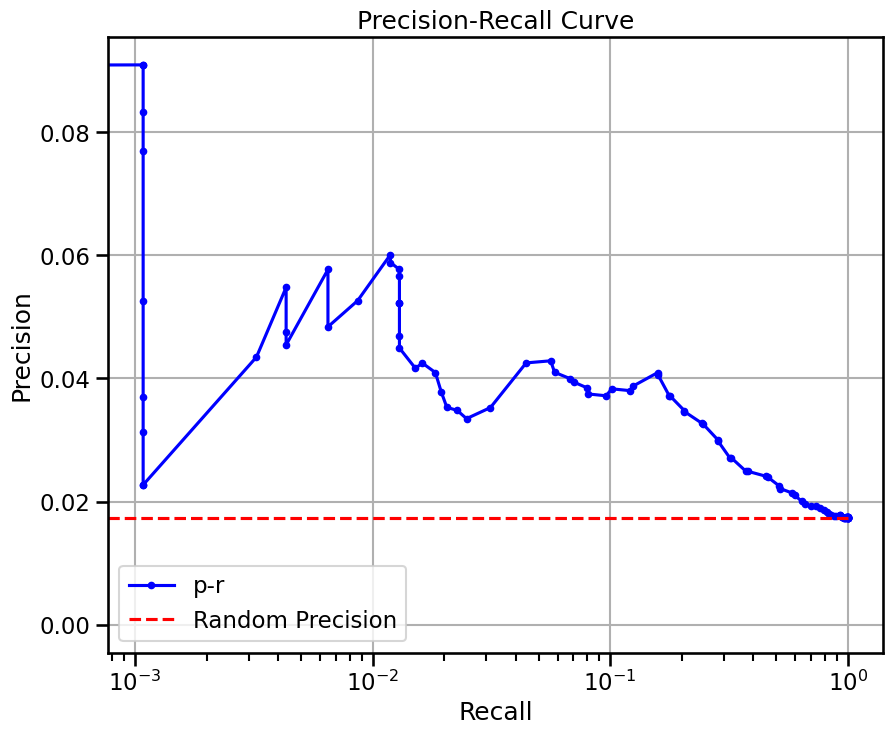

{'precision': 0.01741452589611464,
 'recall': 1.0,
 'rand_precision': 0.017418129149972726,
 'auprc': 0.025751919062668955,
 'epr': 2.4745125192760327}

In [13]:
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

## GWPS

In [21]:
adata = get_perturb_gt()

adata.var["isTF"] = False
adata.var.loc[adata.var.gene_name.isin(utils.TF), "isTF"] = True
adata.var["isTF"].sum()

mpreprocessor = myPreprocessor(force_preprocess=True, skip_validate=True,
                            do_postp=False, min_valid_genes_id=5000, min_dataset_size=64)
nadata = mpreprocessor(adata.copy())
adata

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
removed 0 non primary cells, 10691 renamining
filtered out 0 cells, 10691 renamining
Removed 8 genes.
startin QC
Seeing 10068 outliers (94.17% of total dataset):
done


GRnnData object with n_obs × n_vars = 10691 × 8563
    obs: 'gem_group', 'gene', 'gene_id', 'transcript', 'gene_transcript', 'sgID_AB', 'mitopercent', 'UMI_count', 'z_gemgroup_UMI', 'core_scale_factor', 'core_adjusted_UMI_count', 'organism_ontology_term_id'
    var: 'gene_name', 'chr', 'start', 'end', 'class', 'strand', 'length', 'in_matrix', 'mean', 'std', 'cv', 'fano', 'isTF'
    varp: 'GRN'
    with a grn of 1115065 elements

In [22]:
NUM_GENES = 4000
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=NUM_GENES)
adata.var['symbol'] = adata.var["gene_name"]
adata.var['ensembl_id'] = adata.var.index
subadata = adata[:1024, adata.var.index.isin(genes) & adata.var.highly_variable]
subadata.var = subadata.var.set_index("symbol")

In [23]:
grn = generate_grn(model, vocab, subadata, batch_size = 10, num_attn_layers = 11)

scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Log1p transforming ...
scGPT - INFO - Binning data ...


100%|██████████| 103/103 [00:46<00:00,  2.19it/s]


base enrichment
Top central genes: []


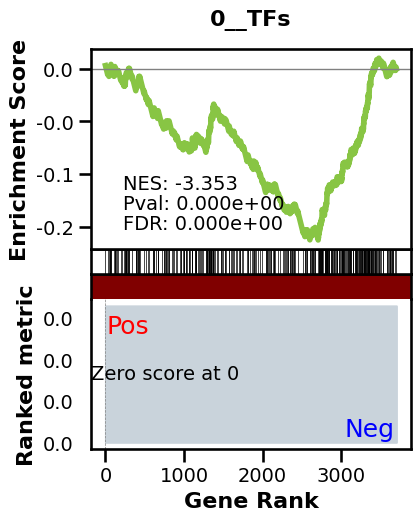

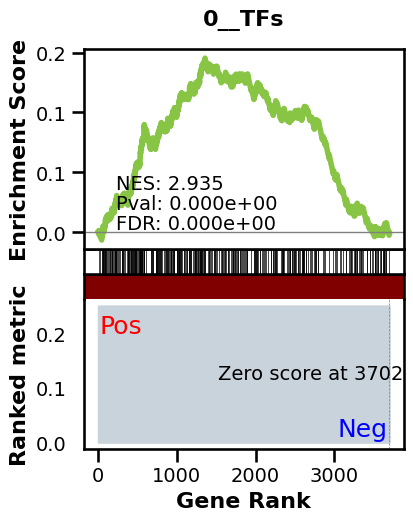

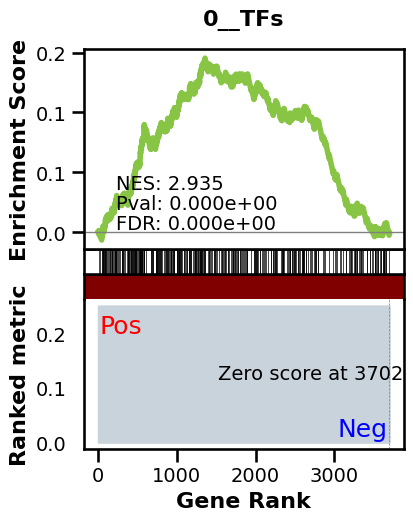

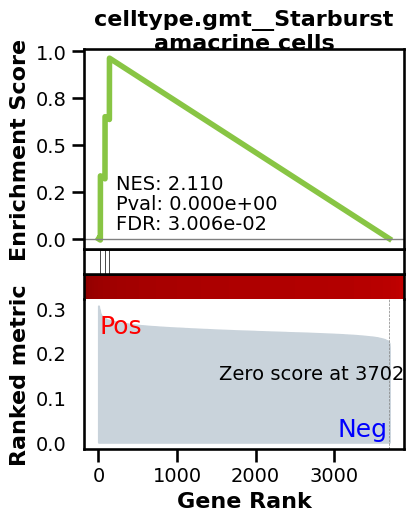

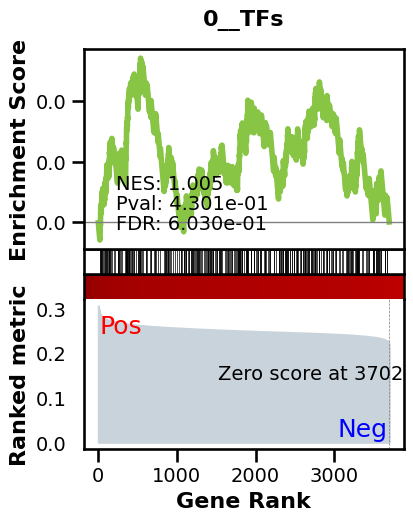

_________________________________________
TF specific enrichment


2024-05-27 13:10:53,673:INFO - Downloading and generating Enrichr library gene sets...
2024-05-27 13:10:53,674:INFO - Library is already downloaded in: /home/ml4ig1/.cache/gseapy/Enrichr.ENCODE_TF_ChIP-seq_2014.gmt, use local file
2024-05-27 13:10:53,914:INFO - 0332 gene_sets have been filtered out when max_size=2000 and min_size=0


found some significant results for  7.8431372549019605 % TFs

_________________________________________
loading GT,  omnipath
intersection of 2583 genes
intersection pct: 0.6975425330812854
precision:  0.001738188390124596 
recall:  1.0 
random precision: 0.0017388615846986178


100%|██████████| 99/99 [00:01<00:00, 97.18it/s] 


Area Under Precision-Recall Curve (AUPRC):  0.0022744948762313225
EPR: 1.091314120978313


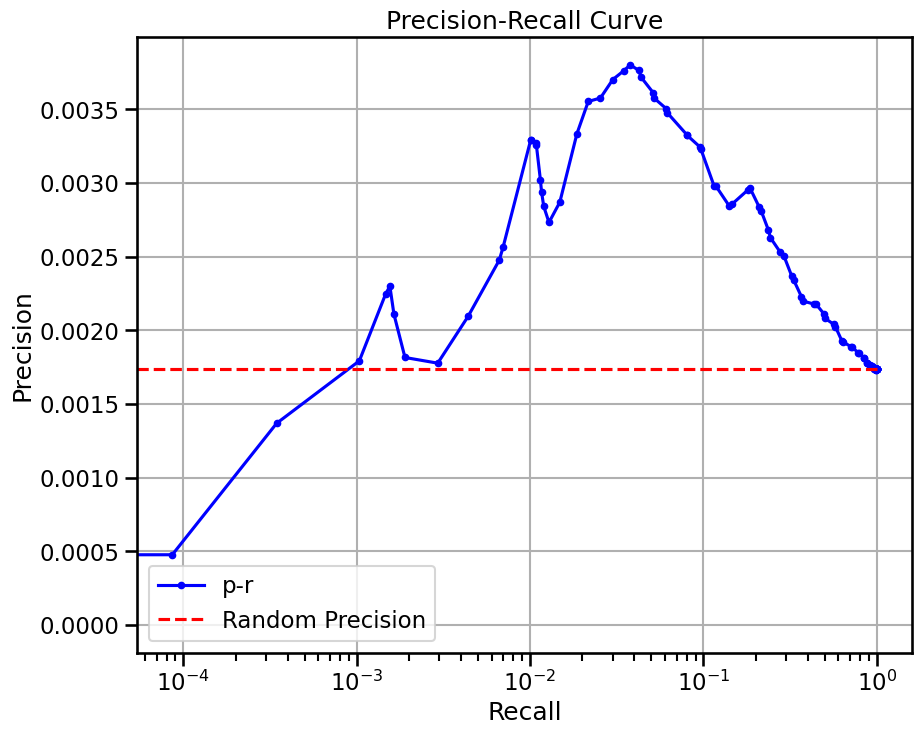

{'TF_enr': True,
 'enriched_terms_Targets': ['0__TFs'],
 'enriched_terms_Regulators': ['celltype.gmt__Starburst amacrine cells',
  'celltype.gmt__Mesangial cells',
  'celltype.gmt__Granulocytes',
  'celltype.gmt__Glycinergic amacrine cells',
  'celltype.gmt__Melanocytes',
  'celltype.gmt__Myocytes',
  'celltype.gmt__Non-classical monocytes'],
 'significant_enriched_TFtargets': 7.8431372549019605,
 'precision': 0.001738188390124596,
 'recall': 1.0,
 'rand_precision': 0.0017388615846986178,
 'auprc': 0.0022744948762313225,
 'EPR': 1.091314120978313}

In [24]:
grn.var['symbol'] = grn.var.index
BenGRN(grn, do_auc=True, doplot=True).scprint_benchmark()

precision:  0.021327256103574353 
recall:  1.0 
random precision: 0.021333017112786557


100%|██████████| 99/99 [00:02<00:00, 33.47it/s]


Area Under Precision-Recall Curve (AUPRC):  0.0242970036365177
EPR: 2.136162707168277


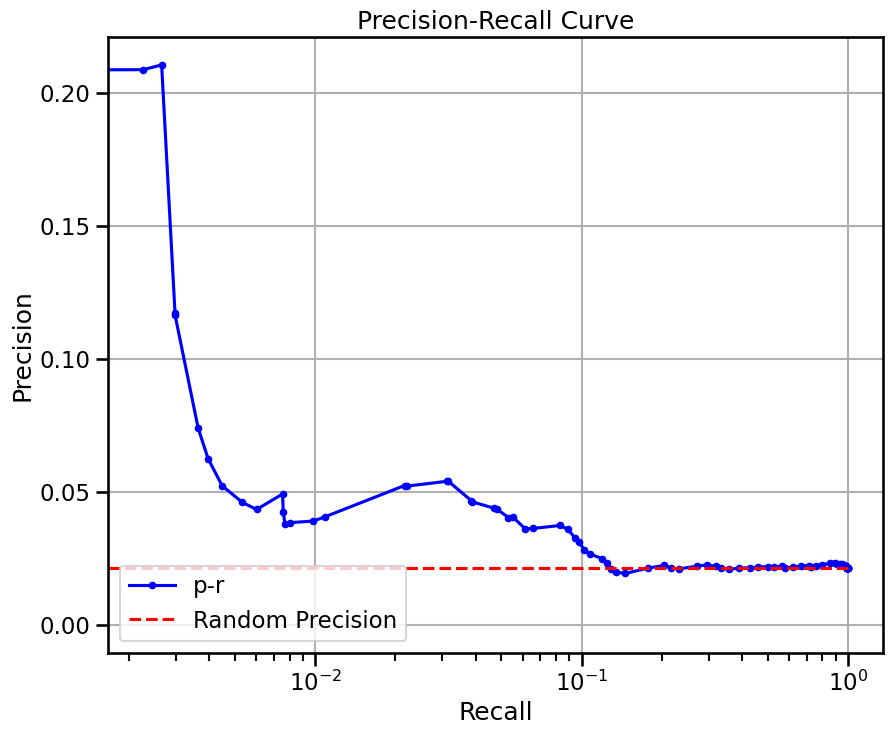

{'precision': 0.021327256103574353,
 'recall': 1.0,
 'rand_precision': 0.021333017112786557,
 'auprc': 0.0242970036365177,
 'EPR': 2.136162707168277}

In [174]:
grn.var = grn.var.set_index('ensembl_id')
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=adata)

## OMNIpath

In [187]:
CELLTYPES = [
    'kidney distal convoluted tubule epithelial cell',
    'kidney loop of Henle thick ascending limb epithelial cell',
    'kidney collecting duct principal cell',
    #'mesangial cell', #cannot do it... too few cells
    'blood vessel smooth muscle cell',
    'podocyte',
    'macrophage',
    'leukocyte',
    'kidney interstitial fibroblast',
    'endothelial cell'
]

In [177]:
adata = sc.read_h5ad('/home/ml4ig1/scprint/.lamindb/yBCKp6HmXuHa0cZptMo7.h5ad')
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(utils.TF), "isTF"] = True
adata

AnnData object with n_obs × n_vars = 15728 × 70116
    obs: 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'sample_uuid', 'sample_preservation_method', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'tissue_section_uuid', 'tissue_section_thickness', 'library_uuid', 'assay_ontology_term_id', 'mapped_reference_annotation', 'is_primary_data', 'cell_type_ontology_term_id', 'author_cell_type', 'disease_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'cell_culture', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'leiden_3', 'leide

scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Log1p transforming ...
scGPT - INFO - Binning data ...


100%|██████████| 86/86 [00:42<00:00,  2.01it/s]


base enrichment
Top central genes: []


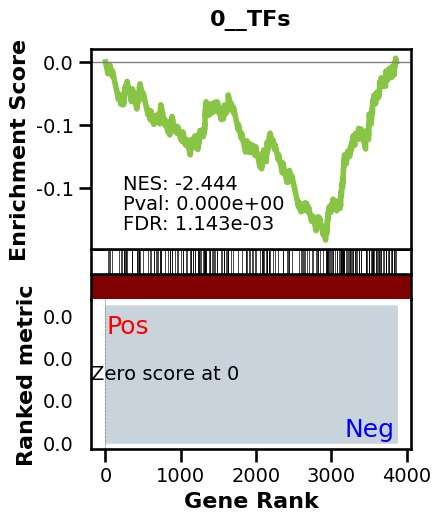

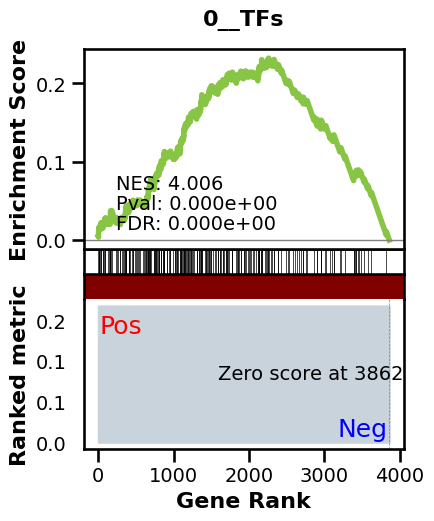

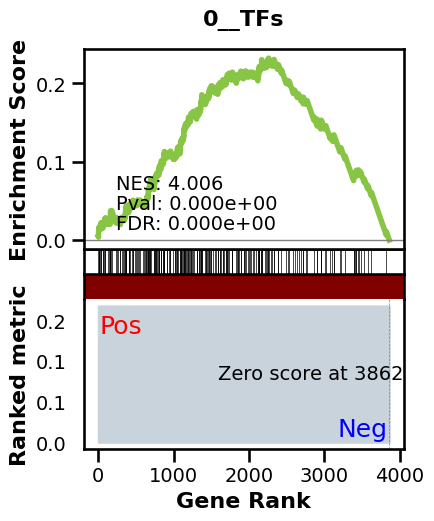

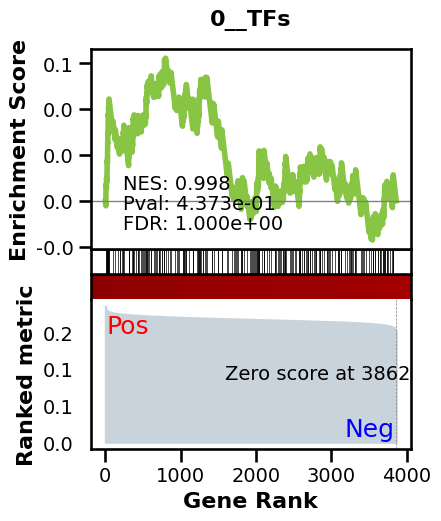

_________________________________________
TF specific enrichment


2024-05-24 13:48:22,324:INFO - Downloading and generating Enrichr library gene sets...
2024-05-24 13:48:22,327:INFO - Library is already downloaded in: /home/ml4ig1/.cache/gseapy/Enrichr.ENCODE_TF_ChIP-seq_2014.gmt, use local file
2024-05-24 13:48:22,566:INFO - 0332 gene_sets have been filtered out when max_size=2000 and min_size=0


found some significant results for  37.93103448275862 % TFs

_________________________________________
loading GT,  omnipath
intersection of 2767 genes
intersection pct: 0.7162826818534818
precision:  0.0011727613730359446 
recall:  1.0 
random precision: 0.0011731853648555529


100%|██████████| 99/99 [00:01<00:00, 82.39it/s]


Area Under Precision-Recall Curve (AUPRC):  0.0014214148805463112
EPR: 0.569006696898899


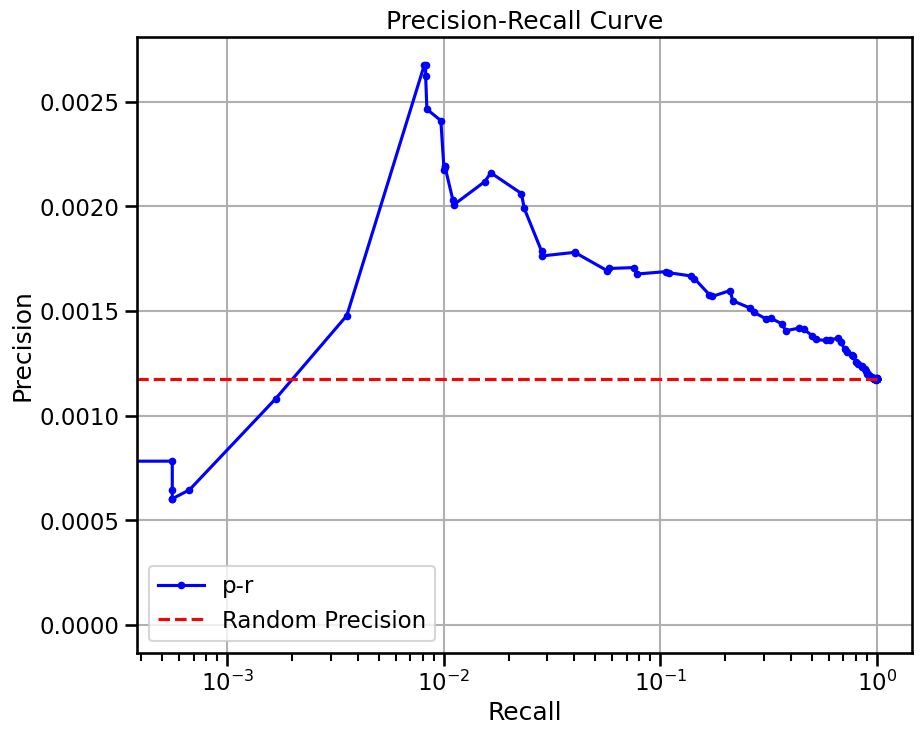

base enrichment
Top central genes: []


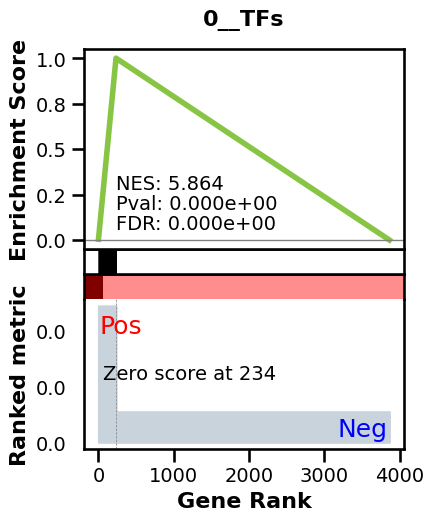

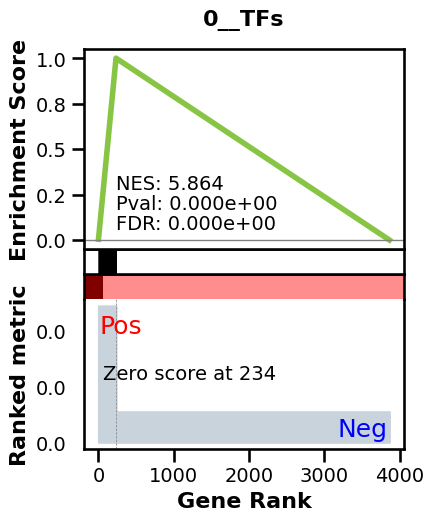

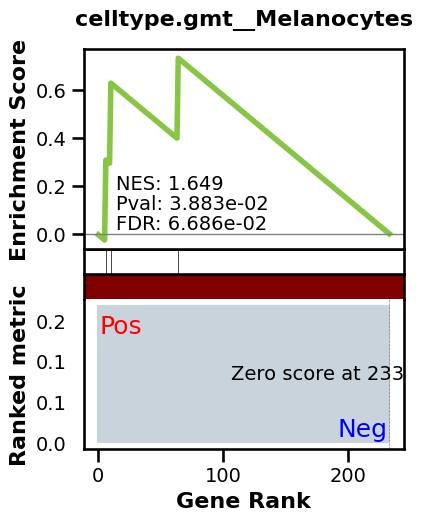

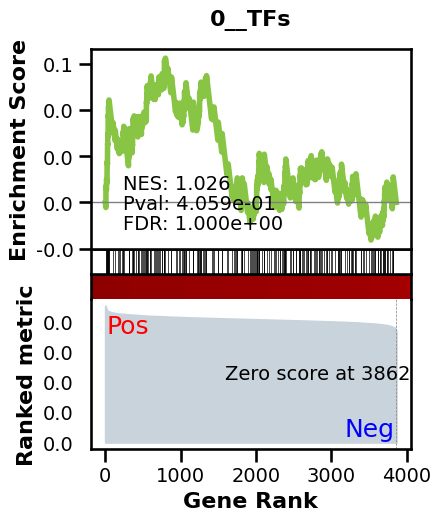

_________________________________________
TF specific enrichment


2024-05-24 13:49:00,956:INFO - Downloading and generating Enrichr library gene sets...
2024-05-24 13:49:00,958:INFO - Library is already downloaded in: /home/ml4ig1/.cache/gseapy/Enrichr.ENCODE_TF_ChIP-seq_2014.gmt, use local file
2024-05-24 13:49:01,156:INFO - 0332 gene_sets have been filtered out when max_size=2000 and min_size=0


found some significant results for  27.586206896551722 % TFs

_________________________________________
loading GT,  omnipath
intersection of 2767 genes
intersection pct: 0.7162826818534818
precision:  0.005833802667038464 
recall:  0.35415970598062146 
random precision: 0.0011731853648555529


100%|██████████| 99/99 [00:01<00:00, 84.51it/s]


Area Under Precision-Recall Curve (AUPRC):  0.004650072009089226
EPR: 8.204849735856572


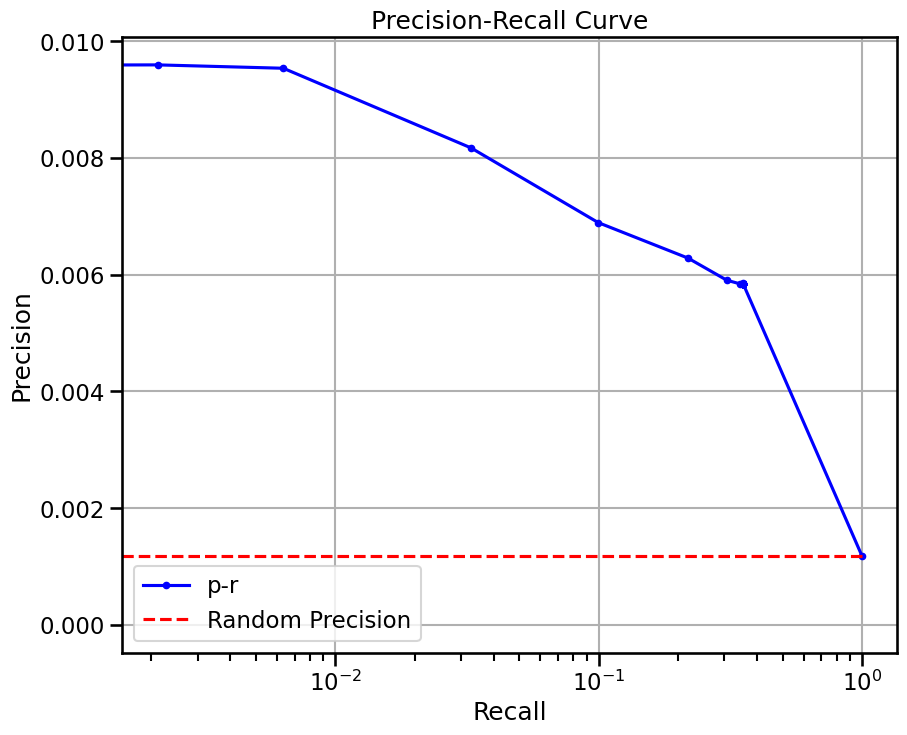

scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Log1p transforming ...
scGPT - INFO - Binning data ...


100%|██████████| 26/26 [00:14<00:00,  1.76it/s]


base enrichment
Top central genes: []


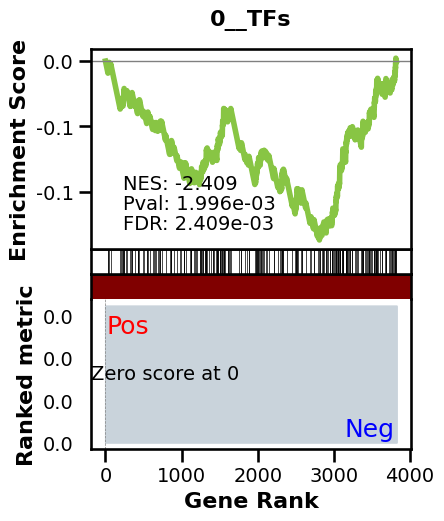

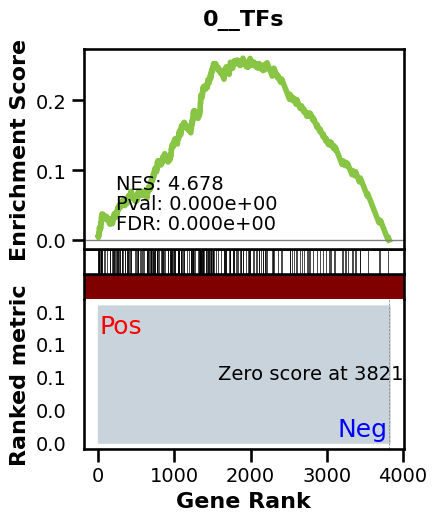

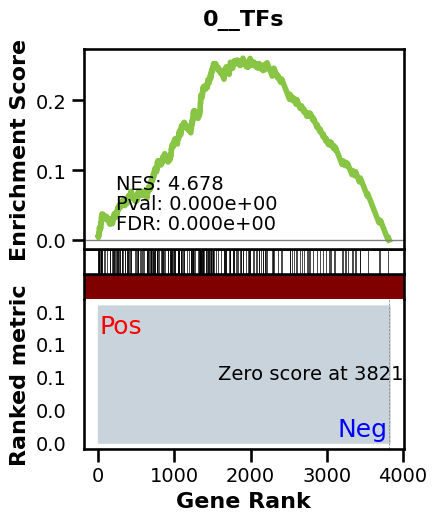

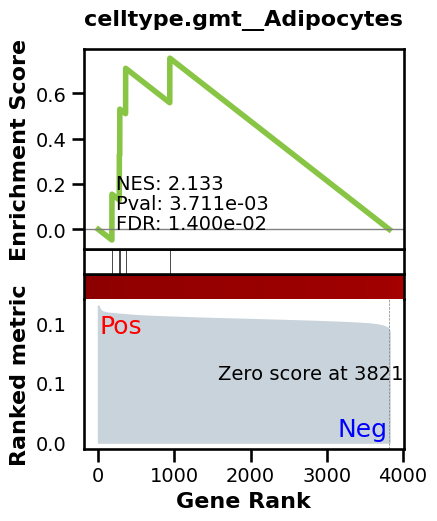

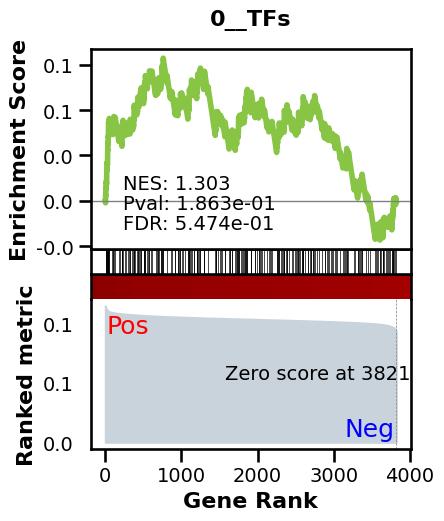

_________________________________________
TF specific enrichment


2024-05-24 13:50:10,495:INFO - Downloading and generating Enrichr library gene sets...
2024-05-24 13:50:10,497:INFO - Library is already downloaded in: /home/ml4ig1/.cache/gseapy/Enrichr.ENCODE_TF_ChIP-seq_2014.gmt, use local file
2024-05-24 13:50:10,735:INFO - 0332 gene_sets have been filtered out when max_size=2000 and min_size=0


found some significant results for  33.333333333333336 % TFs

_________________________________________
loading GT,  omnipath
intersection of 2710 genes
intersection pct: 0.7090528519099948
precision:  0.0011941558529976444 
recall:  1.0 
random precision: 0.0011945966635746091


100%|██████████| 99/99 [00:01<00:00, 86.58it/s]


Area Under Precision-Recall Curve (AUPRC):  0.0014566967646337347
EPR: 0.4766569183494093


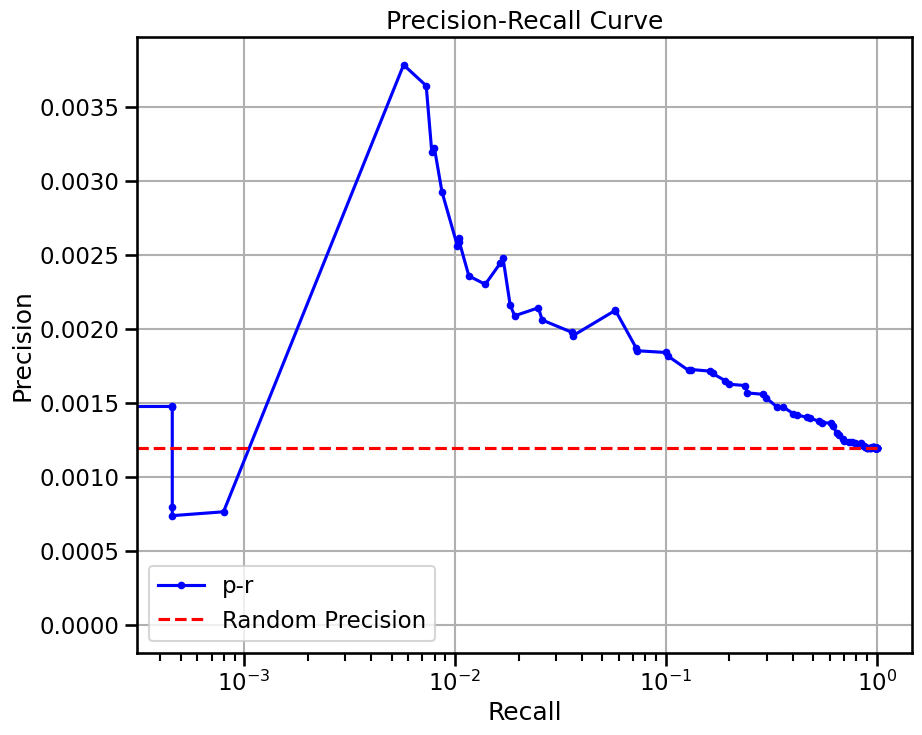

base enrichment
Top central genes: []


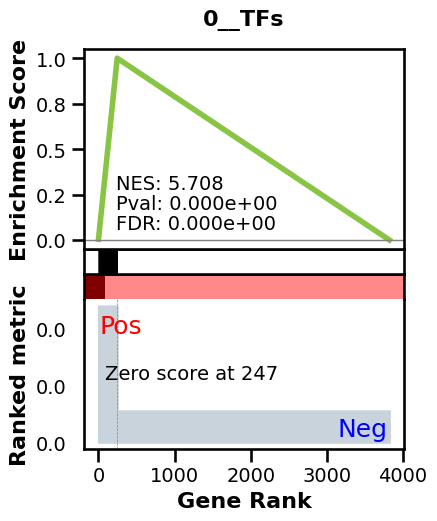

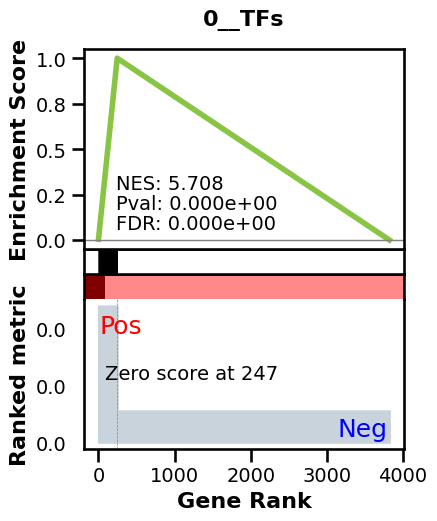

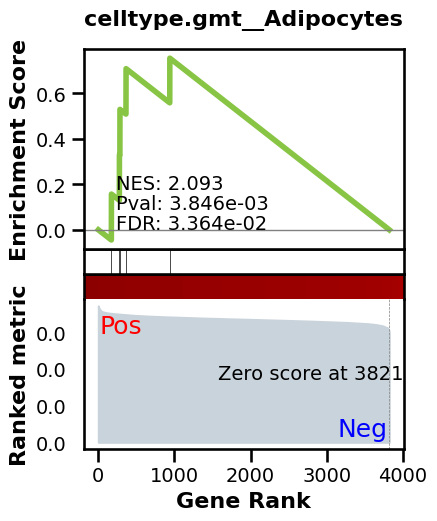

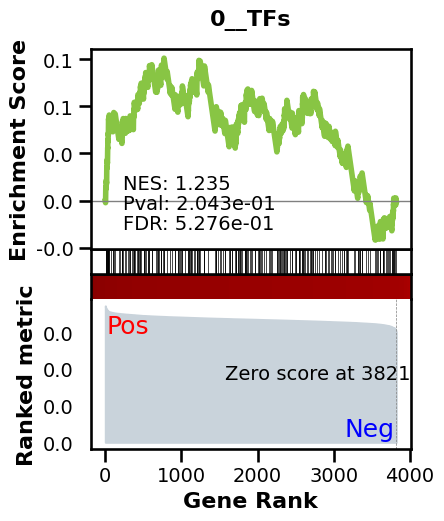

_________________________________________
TF specific enrichment


2024-05-24 13:50:51,007:INFO - Downloading and generating Enrichr library gene sets...
2024-05-24 13:50:51,010:INFO - Library is already downloaded in: /home/ml4ig1/.cache/gseapy/Enrichr.ENCODE_TF_ChIP-seq_2014.gmt, use local file
2024-05-24 13:50:51,210:INFO - 0332 gene_sets have been filtered out when max_size=2000 and min_size=0


found some significant results for  27.272727272727273 % TFs

_________________________________________
loading GT,  omnipath
intersection of 2710 genes
intersection pct: 0.7090528519099948
precision:  0.0070491831678880165 
recall:  0.46396807297605475 
random precision: 0.0011945966635746091


100%|██████████| 99/99 [00:01<00:00, 84.62it/s]


Area Under Precision-Recall Curve (AUPRC):  0.0059046013826964915
EPR: 8.947329518193655


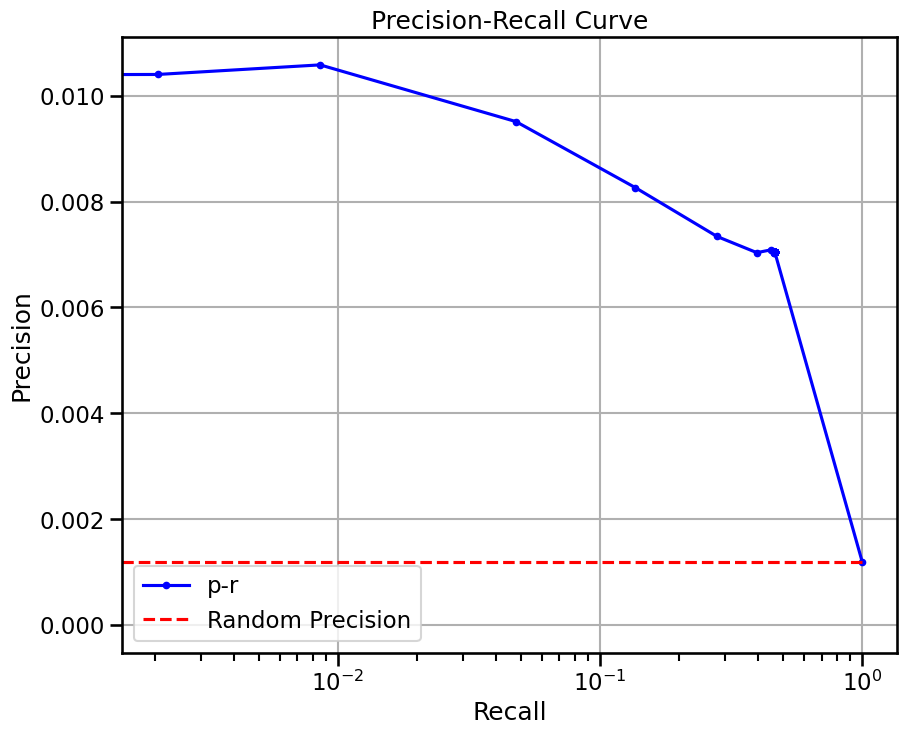

scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Log1p transforming ...
scGPT - INFO - Binning data ...


100%|██████████| 35/35 [00:19<00:00,  1.76it/s]


base enrichment
Top central genes: []


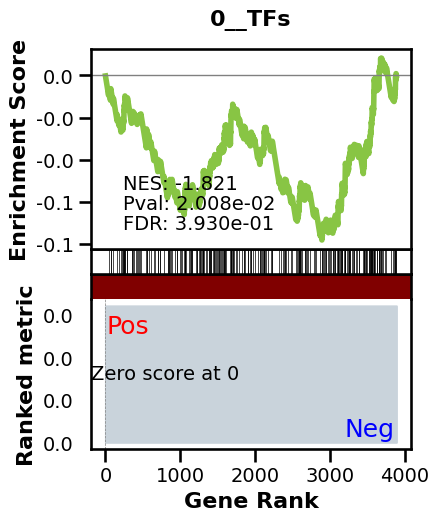

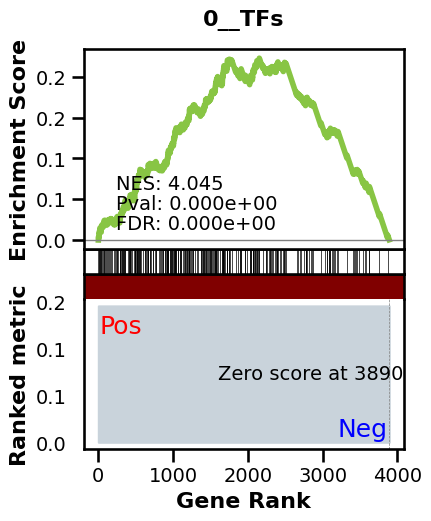

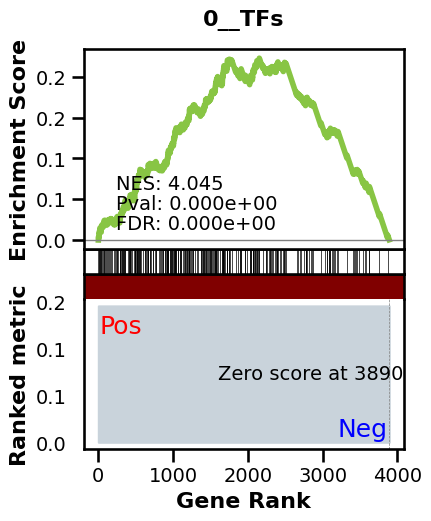

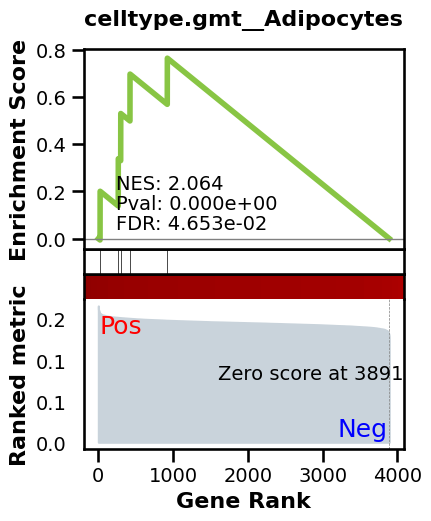

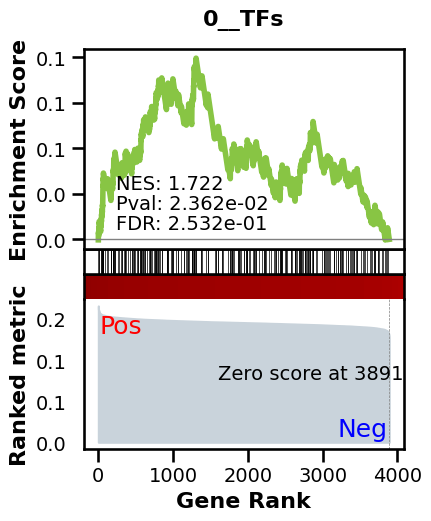

_________________________________________
TF specific enrichment


2024-05-24 13:52:08,087:INFO - Downloading and generating Enrichr library gene sets...
2024-05-24 13:52:08,089:INFO - Library is already downloaded in: /home/ml4ig1/.cache/gseapy/Enrichr.ENCODE_TF_ChIP-seq_2014.gmt, use local file
2024-05-24 13:52:08,287:INFO - 0332 gene_sets have been filtered out when max_size=2000 and min_size=0


found some significant results for  24.193548387096776 % TFs

_________________________________________
loading GT,  omnipath
intersection of 2829 genes
intersection pct: 0.7268756423432683
precision:  0.0015429998921686853 
recall:  1.0 
random precision: 0.0015435455074063686


100%|██████████| 99/99 [00:01<00:00, 76.53it/s]


Area Under Precision-Recall Curve (AUPRC):  0.0019211064129502963
EPR: 4.024258170351917


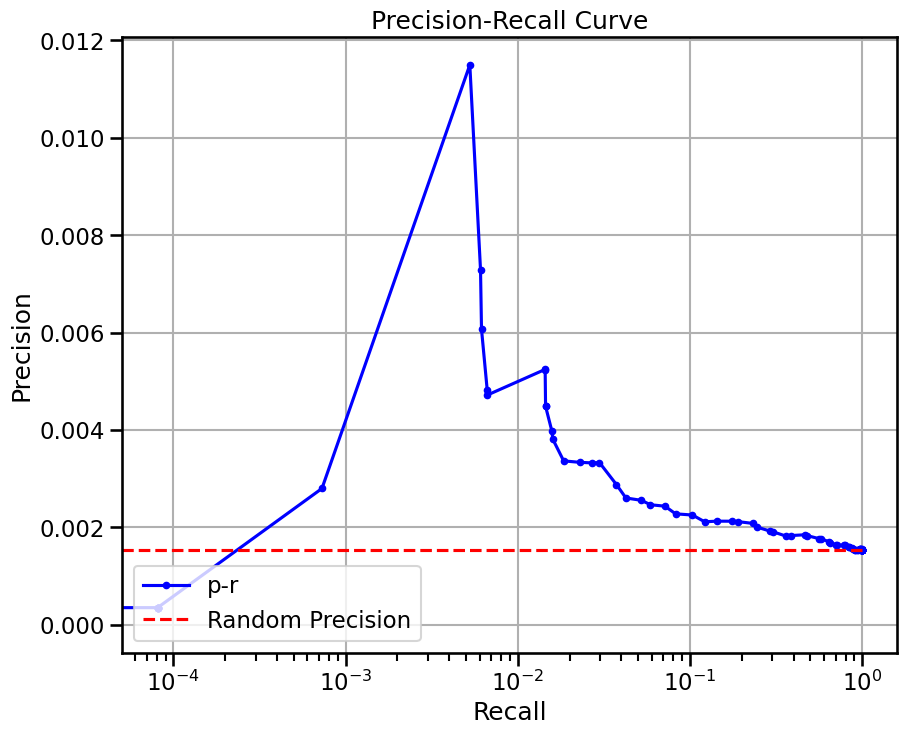

base enrichment
Top central genes: []


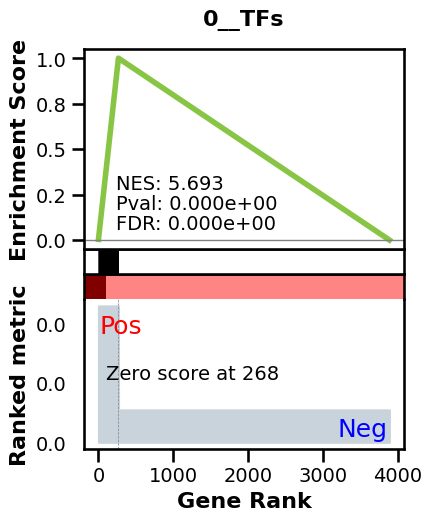

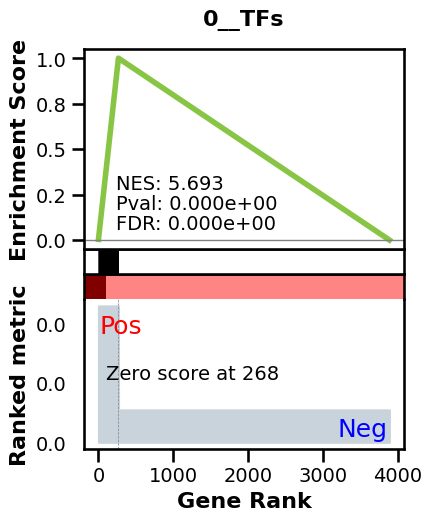

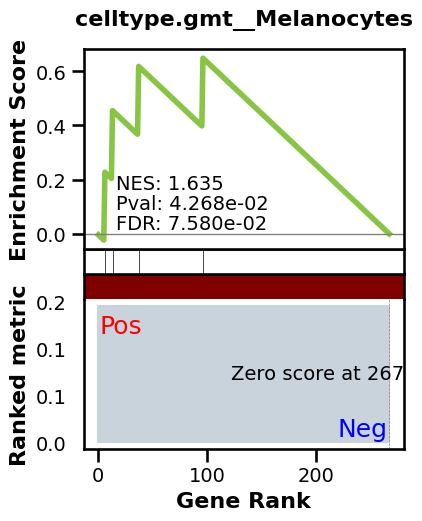

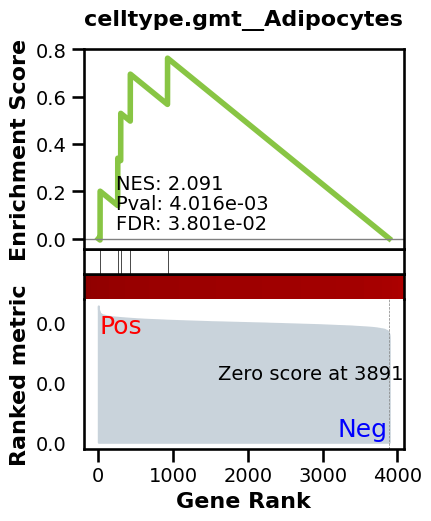

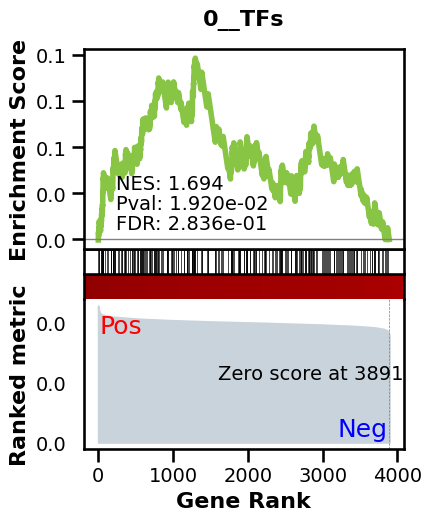

_________________________________________
TF specific enrichment


2024-05-24 13:52:56,704:INFO - Downloading and generating Enrichr library gene sets...
2024-05-24 13:52:56,706:INFO - Library is already downloaded in: /home/ml4ig1/.cache/gseapy/Enrichr.ENCODE_TF_ChIP-seq_2014.gmt, use local file
2024-05-24 13:52:56,901:INFO - 0332 gene_sets have been filtered out when max_size=2000 and min_size=0


found some significant results for  19.35483870967742 % TFs

_________________________________________
loading GT,  omnipath
intersection of 2829 genes
intersection pct: 0.7268756423432683
precision:  0.008578326301301866 
recall:  0.4618187707506681 
random precision: 0.0015435455074063686


100%|██████████| 99/99 [00:01<00:00, 76.97it/s]


Area Under Precision-Recall Curve (AUPRC):  0.007685425483048896
EPR: 10.8076032715331


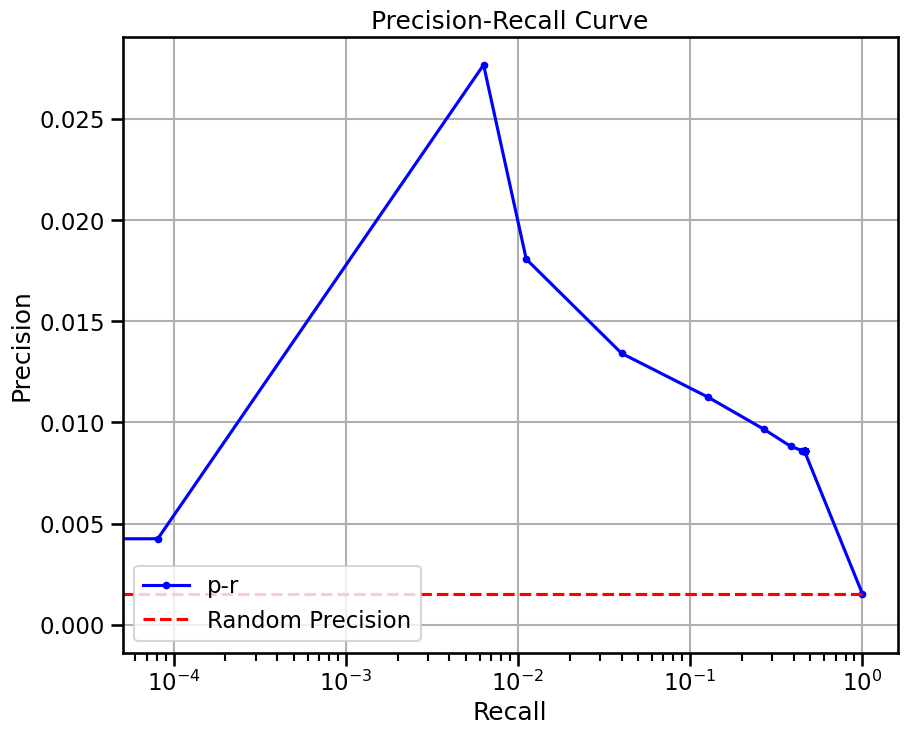

TypeError: __contains__(): incompatible function arguments. The following argument types are supported:
    1. (self: torchtext._torchtext.Vocab, arg0: str) -> bool

Invoked with: <torchtext._torchtext.Vocab object at 0x7effe65ad230>, nan

In [182]:
sc.tl.rank_genes_groups(
    adata, groupby="cell_type"
)
adata.var['ensembl_id'] = adata.var.index
metrics = {}
for celltype in CELLTYPES:
    to_use = adata.uns["rank_genes_groups"]["names"][celltype][
        : NUM_GENES
    ].tolist()
    subadata = adata[adata.obs.cell_type == celltype]
    subadata = subadata[subadata.X.sum(1) > 500][:1024, adata.var.index.isin(
        genes) & adata.var.index.isin(to_use)]
    subadata.var = subadata.var.set_index('feature_name')
    all_gene_ids, all_values, src_key_padding_mask, subadata = prepare_dataset(subadata)
    sum_attn_scores = generate_grn(model, all_gene_ids, all_values, src_key_padding_mask, batch_size = 10, num_attn_layers = 11)
    grn = GRNAnnData(subadata, grn=sum_attn_scores[1:,1:])
    metrics[celltype+'_scgpt'] = BenGRN(grn).scprint_benchmark()
    grn.varp['GRN'][~grn.var.isTF,:]=0
    metrics[celltype+'_scgpt'] = BenGRN(grn).scprint_benchmark()

In [183]:
metrics

{'kidney distal convoluted tubule epithelial cell_scgpt': {'enriched_terms_Central': ['0__TFs',
   'celltype.gmt__Embryonic stem cells',
   'celltype.gmt__Melanocytes',
   'celltype.gmt__Hepatoblasts'],
  'TF_enr': True,
  'enriched_terms_Targets': ['celltype.gmt__Melanocytes'],
  'significant_enriched_TFtargets': 27.586206896551722,
  'precision': 0.005833802667038464,
  'recall': 0.35415970598062146,
  'rand_precision': 0.0011731853648555529,
  'auprc': 0.004650072009089226,
  'EPR': 8.204849735856572},
 'kidney loop of Henle thick ascending limb epithelial cell_scgpt': {'enriched_terms_Central': ['0__TFs',
   'celltype.gmt__Embryonic stem cells',
   'celltype.gmt__Loop of Henle cells',
   'celltype.gmt__Delta cells',
   'celltype.gmt__Microfold cells'],
  'TF_enr': True,
  'enriched_terms_Regulators': ['celltype.gmt__Adipocytes'],
  'significant_enriched_TFtargets': 27.272727272727273,
  'precision': 0.0070491831678880165,
  'recall': 0.46396807297605475,
  'rand_precision': 0.00119

scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Log1p transforming ...
scGPT - INFO - Binning data ...


100%|██████████| 22/22 [00:10<00:00,  2.06it/s]


base enrichment
Top central genes: []


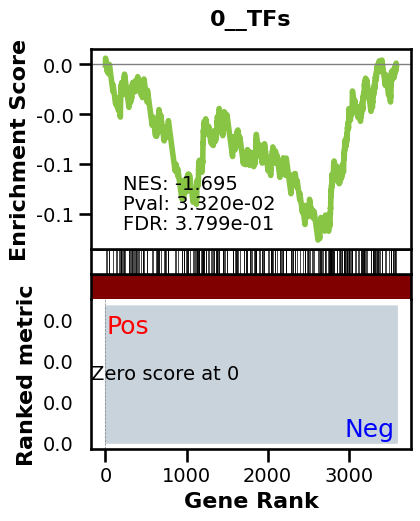

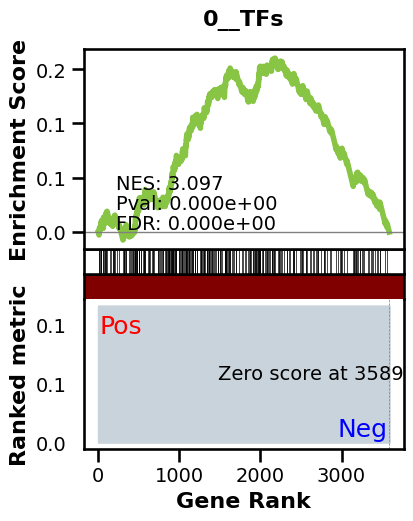

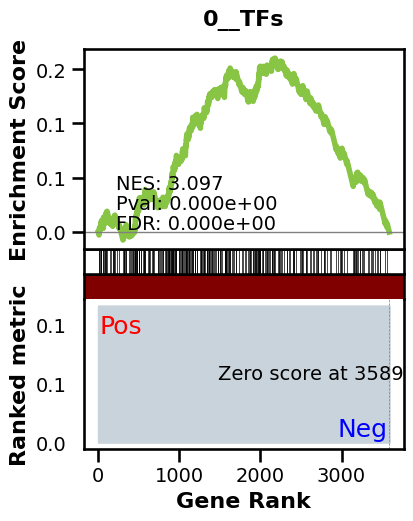

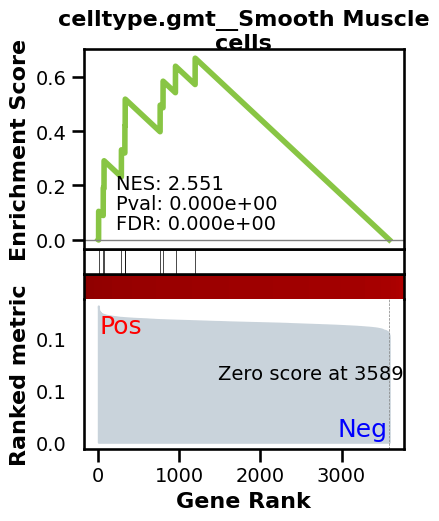

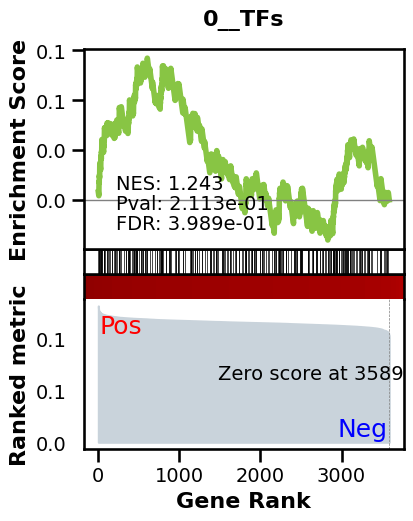

_________________________________________
TF specific enrichment


2024-05-24 14:02:57,941:INFO - Downloading and generating Enrichr library gene sets...
2024-05-24 14:02:57,943:INFO - Library is already downloaded in: /home/ml4ig1/.cache/gseapy/Enrichr.ENCODE_TF_ChIP-seq_2014.gmt, use local file
2024-05-24 14:02:58,163:INFO - 0332 gene_sets have been filtered out when max_size=2000 and min_size=0


found some significant results for  31.25 % TFs

_________________________________________
loading GT,  omnipath
intersection of 2642 genes
intersection pct: 0.735933147632312
precision:  0.0016379271317980494 
recall:  1.0 
random precision: 0.0016385473238206916


100%|██████████| 99/99 [00:01<00:00, 88.25it/s]


Area Under Precision-Recall Curve (AUPRC):  0.002042725783337357
EPR: 3.6069434745677773


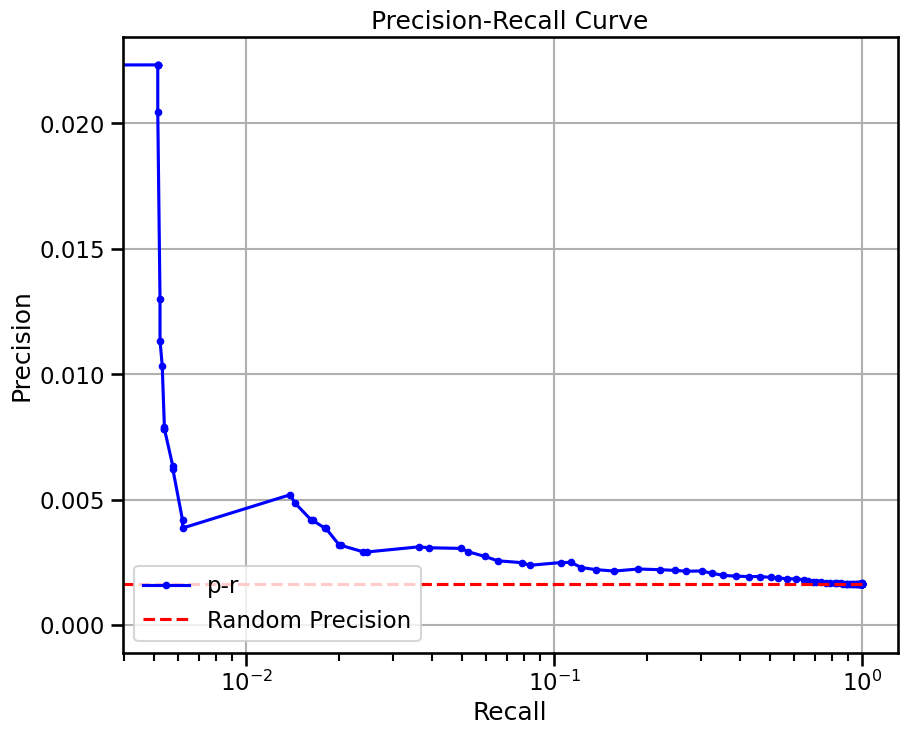

base enrichment
Top central genes: []


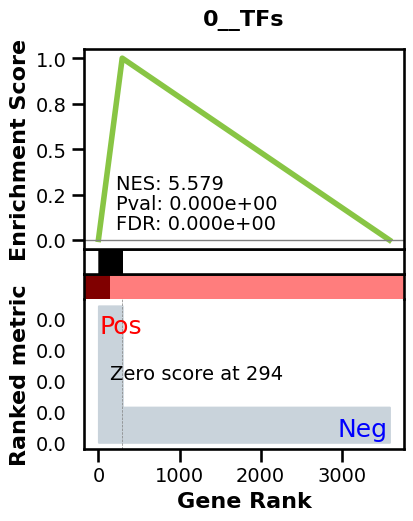

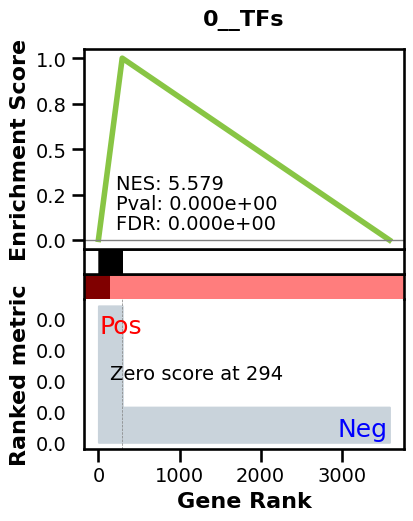

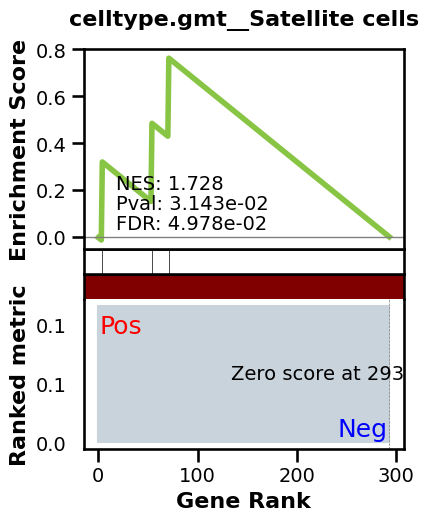

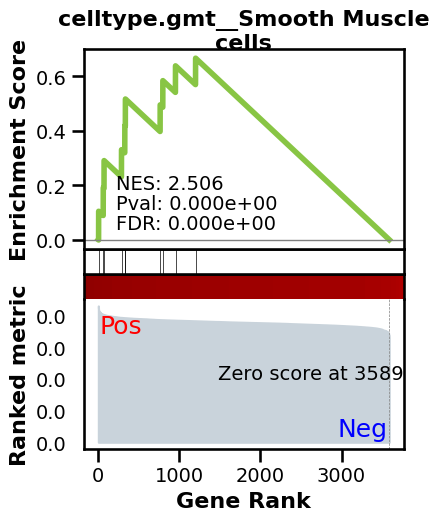

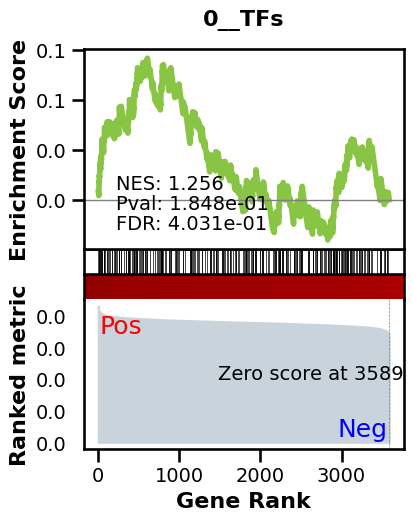

_________________________________________
TF specific enrichment


2024-05-24 14:03:40,769:INFO - Downloading and generating Enrichr library gene sets...
2024-05-24 14:03:40,771:INFO - Library is already downloaded in: /home/ml4ig1/.cache/gseapy/Enrichr.ENCODE_TF_ChIP-seq_2014.gmt, use local file
2024-05-24 14:03:40,967:INFO - 0332 gene_sets have been filtered out when max_size=2000 and min_size=0


found some significant results for  27.083333333333332 % TFs

_________________________________________
loading GT,  omnipath
intersection of 2642 genes
intersection pct: 0.735933147632312
precision:  0.007374993499026298 
recall:  0.44651447564068925 
random precision: 0.0016385473238206916


100%|██████████| 99/99 [00:01<00:00, 85.51it/s]


Area Under Precision-Recall Curve (AUPRC):  0.006587314946516312
EPR: 8.138513179625487


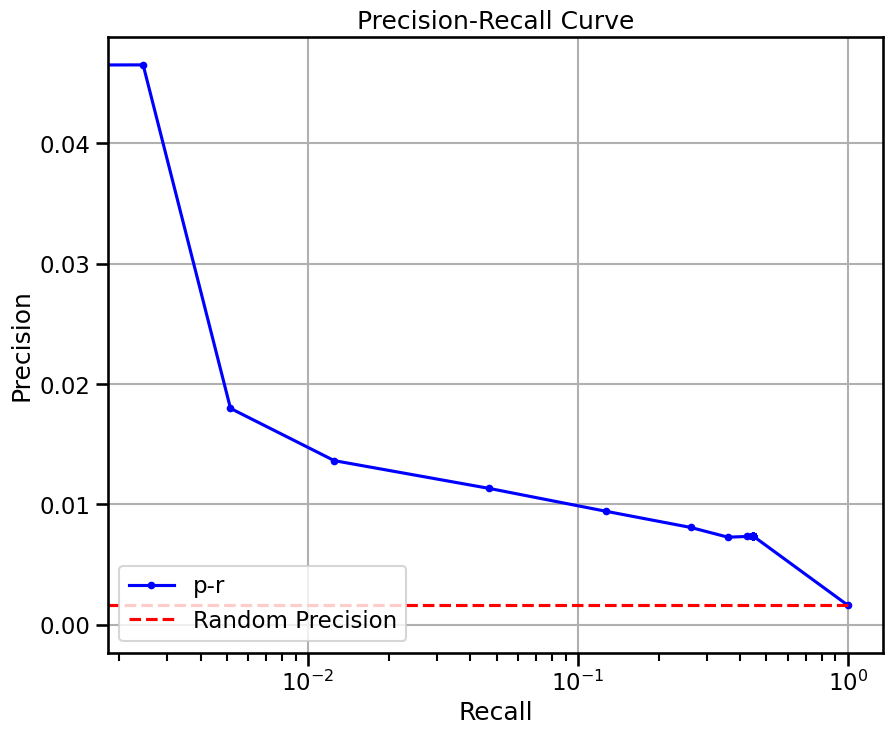

scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Log1p transforming ...
scGPT - INFO - Binning data ...


100%|██████████| 36/36 [00:19<00:00,  1.89it/s]


base enrichment
Top central genes: []


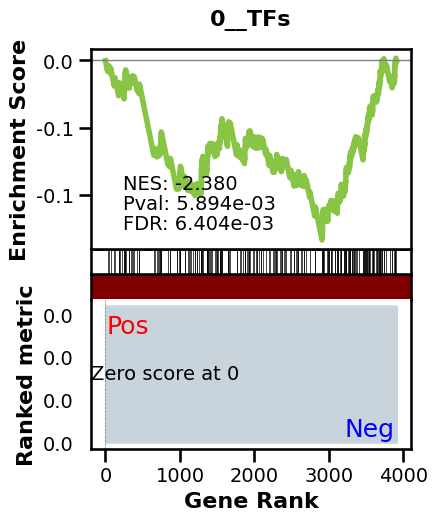

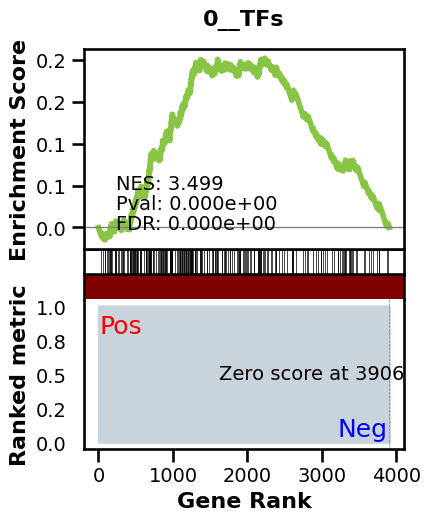

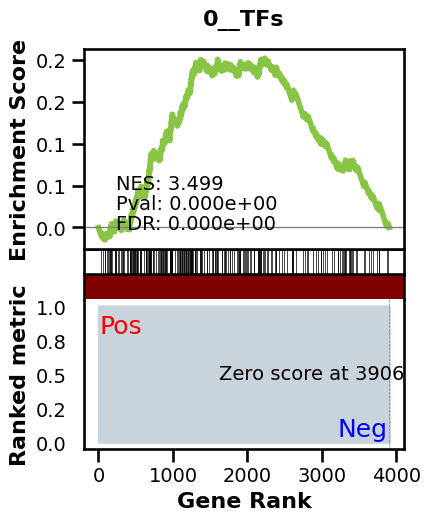

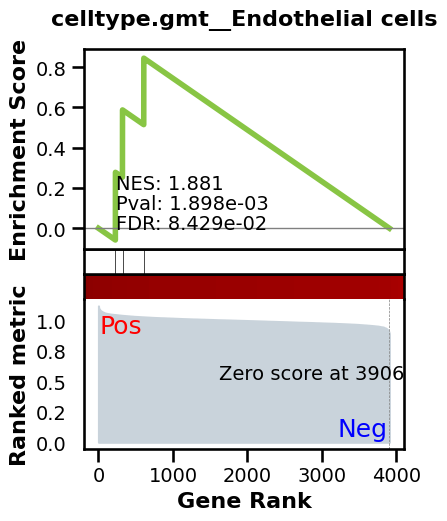

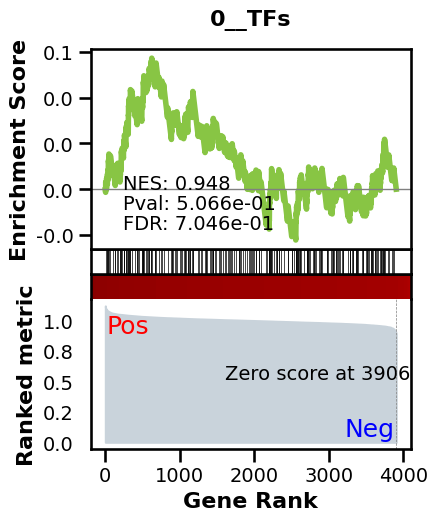

_________________________________________
TF specific enrichment


2024-05-24 14:05:00,605:INFO - Downloading and generating Enrichr library gene sets...
2024-05-24 14:05:00,608:INFO - Library is already downloaded in: /home/ml4ig1/.cache/gseapy/Enrichr.ENCODE_TF_ChIP-seq_2014.gmt, use local file
2024-05-24 14:05:00,797:INFO - 0332 gene_sets have been filtered out when max_size=2000 and min_size=0


found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath
intersection of 2860 genes
intersection pct: 0.7320194522651651
precision:  0.0015053303340016627 
recall:  1.0 
random precision: 0.0015058568573783685


100%|██████████| 99/99 [00:01<00:00, 78.10it/s]


Area Under Precision-Recall Curve (AUPRC):  0.0017784891415937934
EPR: 1.4581910383247771


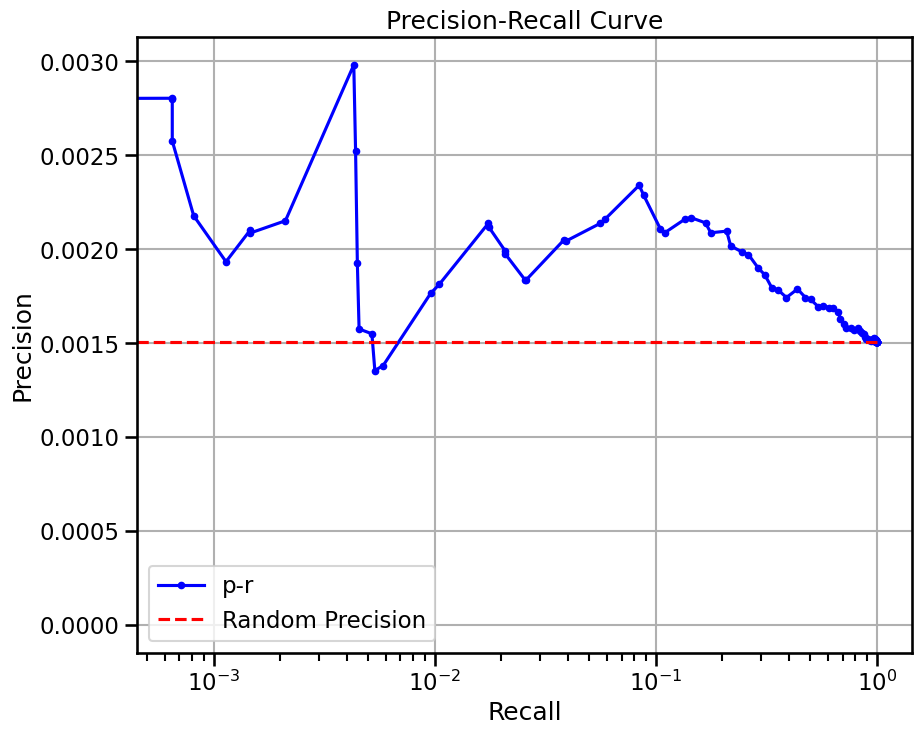

base enrichment
Top central genes: []


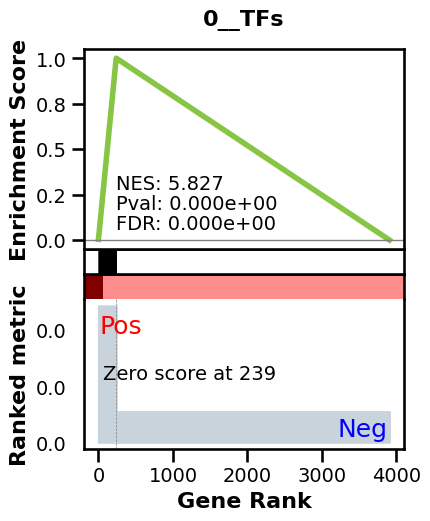

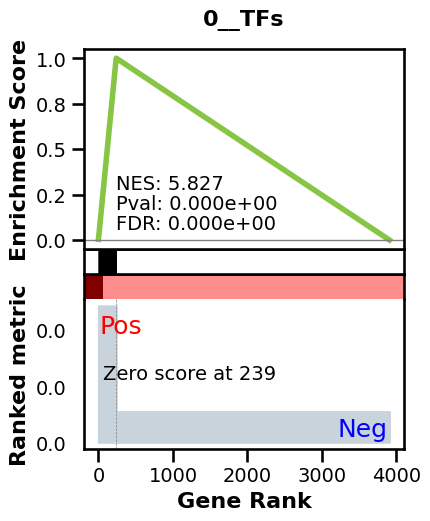

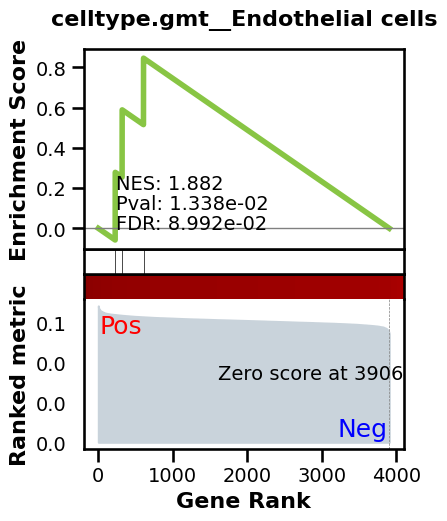

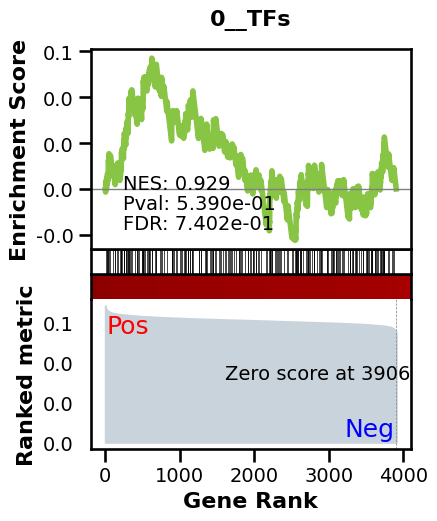

_________________________________________
TF specific enrichment


2024-05-24 14:05:40,955:INFO - Downloading and generating Enrichr library gene sets...
2024-05-24 14:05:40,957:INFO - Library is already downloaded in: /home/ml4ig1/.cache/gseapy/Enrichr.ENCODE_TF_ChIP-seq_2014.gmt, use local file
2024-05-24 14:05:41,149:INFO - 0332 gene_sets have been filtered out when max_size=2000 and min_size=0


found some significant results for  0.0 % TFs

_________________________________________
loading GT,  omnipath
intersection of 2860 genes
intersection pct: 0.7320194522651651
precision:  0.00824524312896406 
recall:  0.4117599285308211 
random precision: 0.0015058568573783685


100%|██████████| 99/99 [00:01<00:00, 78.19it/s]


Area Under Precision-Recall Curve (AUPRC):  0.0066450517078790045
EPR: 6.692030501502683


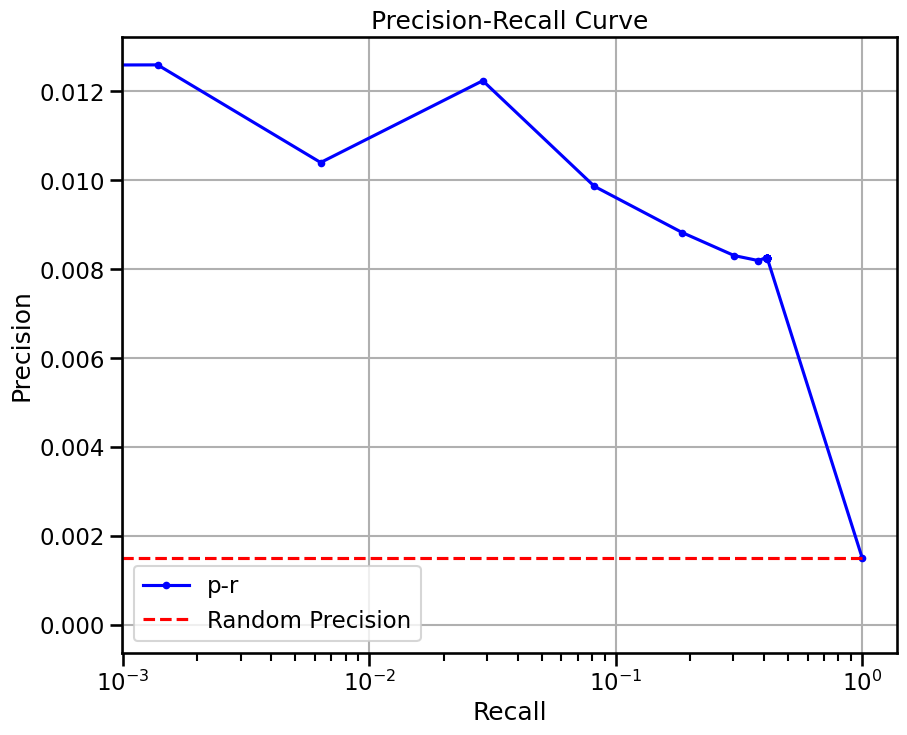

scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Log1p transforming ...
scGPT - INFO - Binning data ...


100%|██████████| 5/5 [00:01<00:00,  4.68it/s]


base enrichment
Top central genes: []


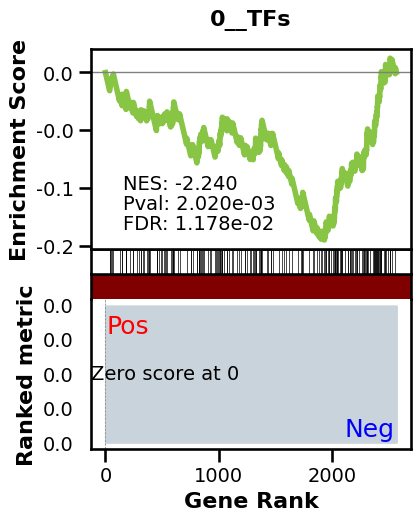

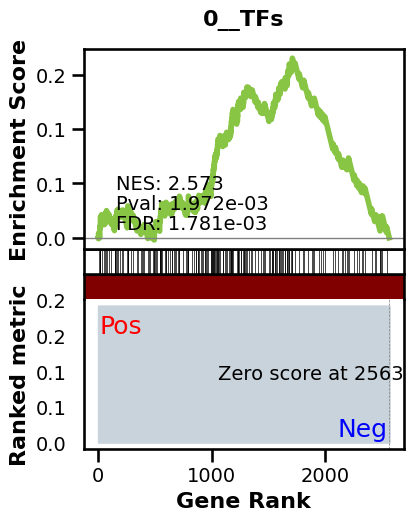

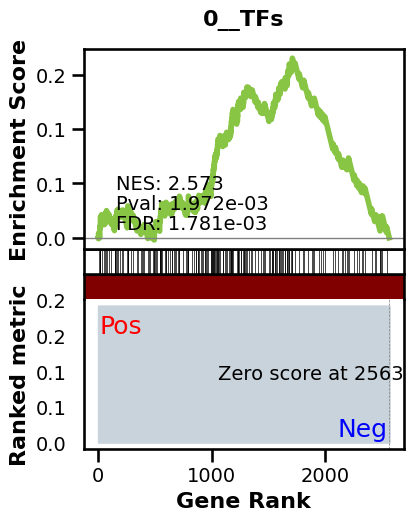

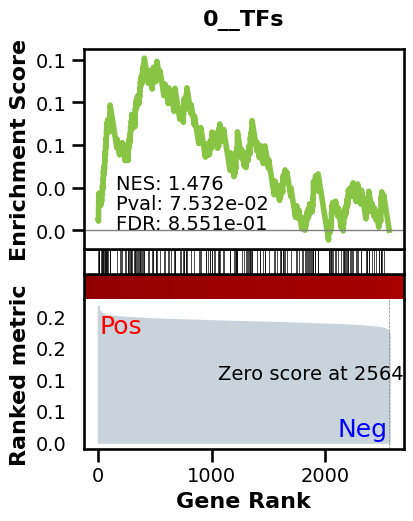

_________________________________________
TF specific enrichment


2024-05-24 14:06:19,997:INFO - Downloading and generating Enrichr library gene sets...
2024-05-24 14:06:19,999:INFO - Library is already downloaded in: /home/ml4ig1/.cache/gseapy/Enrichr.ENCODE_TF_ChIP-seq_2014.gmt, use local file
2024-05-24 14:06:20,190:INFO - 0332 gene_sets have been filtered out when max_size=2000 and min_size=0


found some significant results for  38.23529411764706 % TFs

_________________________________________
loading GT,  omnipath
intersection of 1893 genes
intersection pct: 0.7380116959064328
precision:  0.001882543884397406 
recall:  1.0 
random precision: 0.00188353888645047


100%|██████████| 99/99 [00:00<00:00, 182.45it/s]


Area Under Precision-Recall Curve (AUPRC):  0.0025072544664056493
EPR: 5.767684435344076


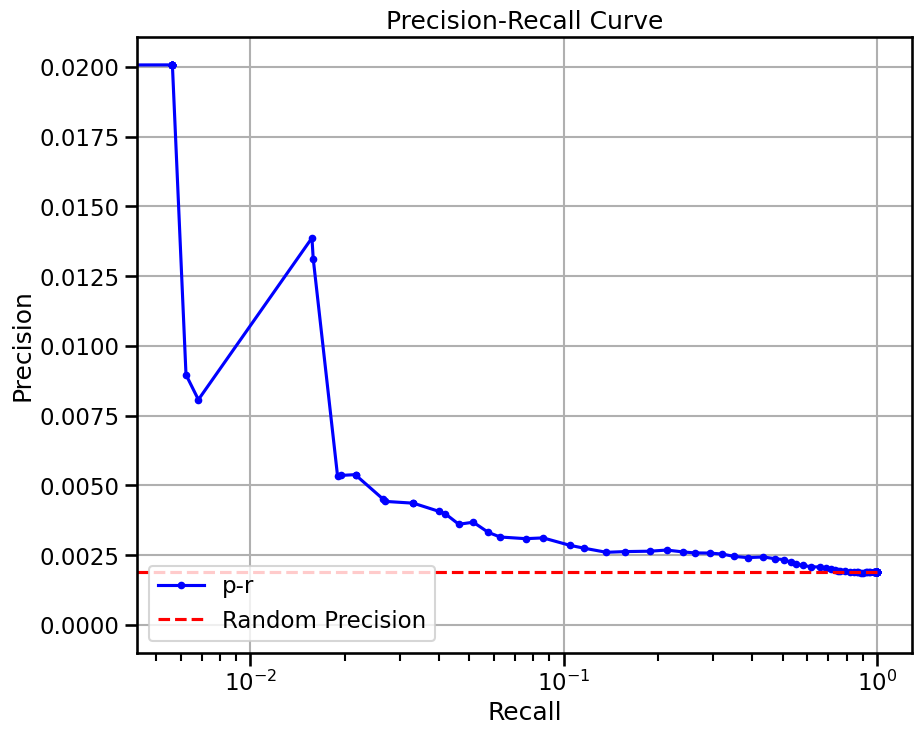

base enrichment
Top central genes: []


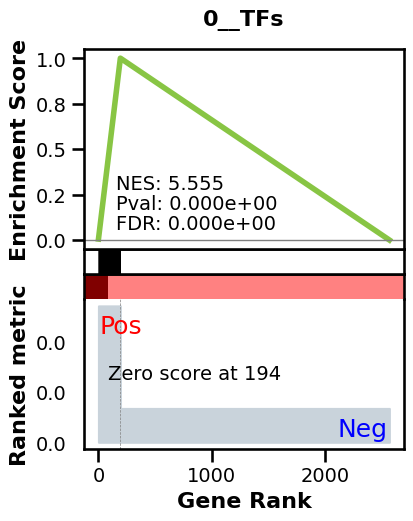

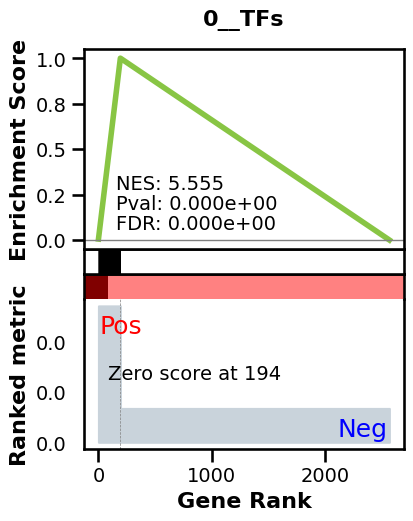

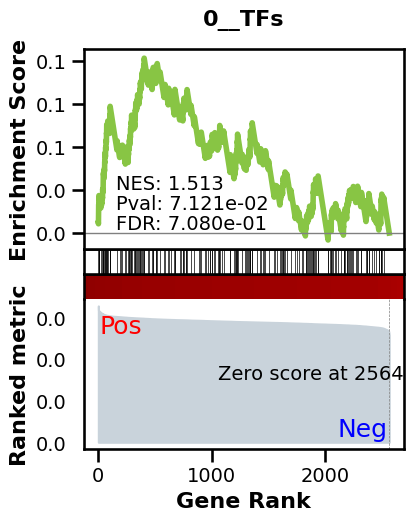

_________________________________________
TF specific enrichment


2024-05-24 14:06:44,697:INFO - Downloading and generating Enrichr library gene sets...
2024-05-24 14:06:44,699:INFO - Library is already downloaded in: /home/ml4ig1/.cache/gseapy/Enrichr.ENCODE_TF_ChIP-seq_2014.gmt, use local file
2024-05-24 14:06:44,904:INFO - 0332 gene_sets have been filtered out when max_size=2000 and min_size=0


found some significant results for  35.294117647058826 % TFs

_________________________________________
loading GT,  omnipath
intersection of 1893 genes
intersection pct: 0.7380116959064328
precision:  0.009730343491751219 
recall:  0.4750963533946042 
random precision: 0.00188353888645047


100%|██████████| 99/99 [00:00<00:00, 175.44it/s]


Area Under Precision-Recall Curve (AUPRC):  0.009178215007579694
EPR: 10.682187063117848


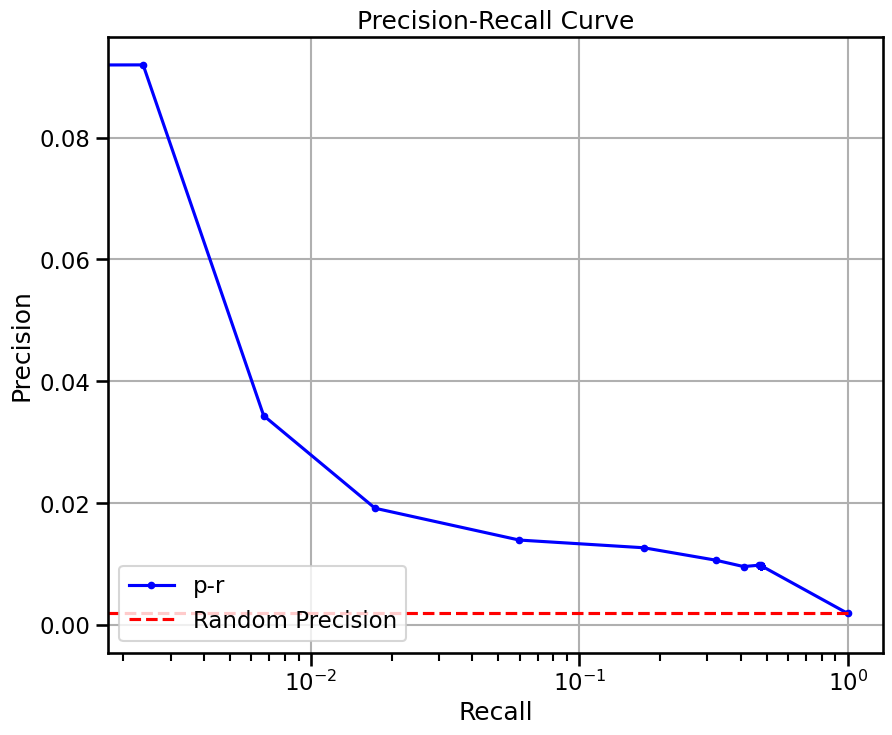

scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Log1p transforming ...
scGPT - INFO - Binning data ...


100%|██████████| 26/26 [00:02<00:00, 11.86it/s]


base enrichment
Top central genes: []


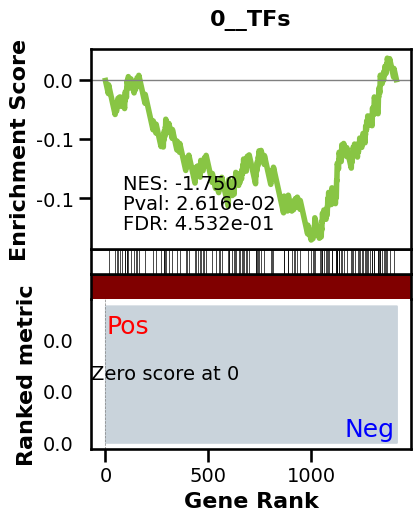

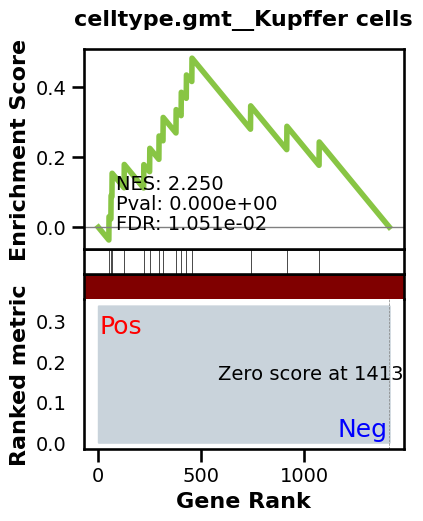

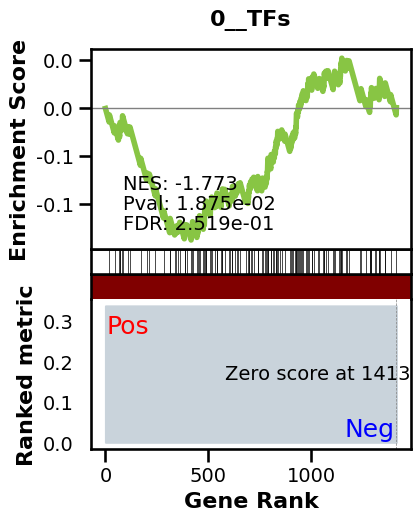

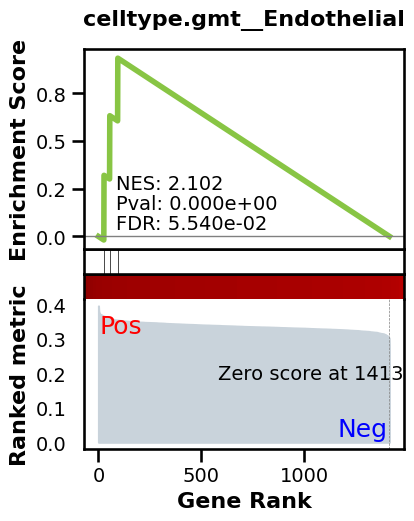

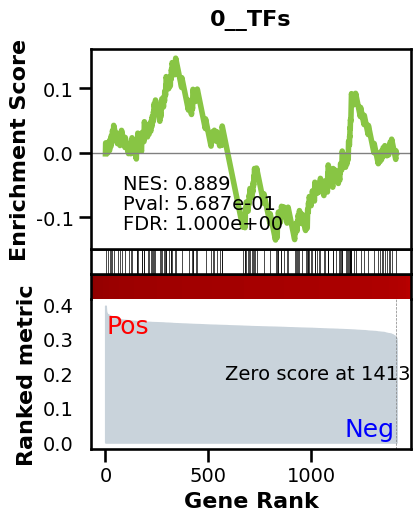

_________________________________________
TF specific enrichment


2024-05-24 14:07:10,870:INFO - Downloading and generating Enrichr library gene sets...
2024-05-24 14:07:10,872:INFO - Library is already downloaded in: /home/ml4ig1/.cache/gseapy/Enrichr.ENCODE_TF_ChIP-seq_2014.gmt, use local file
2024-05-24 14:07:11,088:INFO - 0332 gene_sets have been filtered out when max_size=2000 and min_size=0


found some significant results for  12.5 % TFs

_________________________________________
loading GT,  omnipath
intersection of 1000 genes
intersection pct: 0.7072135785007072
precision:  0.001791 
recall:  1.0 
random precision: 0.0017927927927927929


100%|██████████| 99/99 [00:00<00:00, 567.92it/s]


Area Under Precision-Recall Curve (AUPRC):  0.002566134024924859
EPR: 9.62988545109978


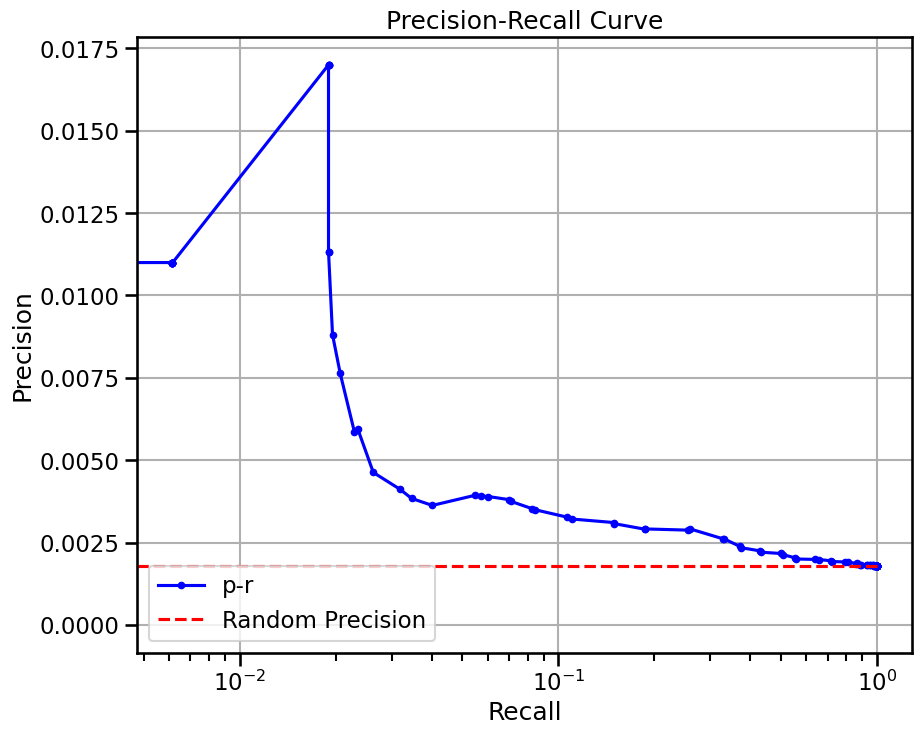

base enrichment
Top central genes: []


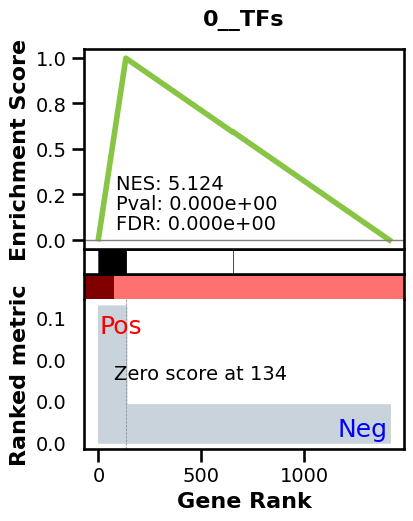

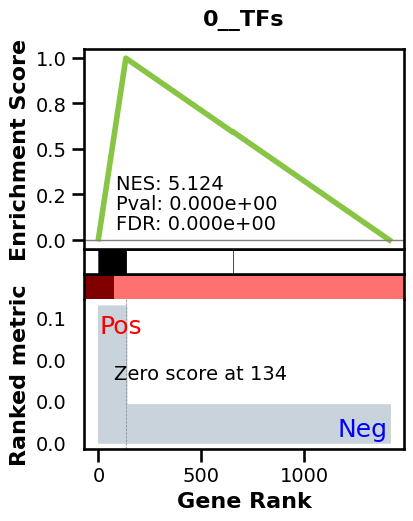

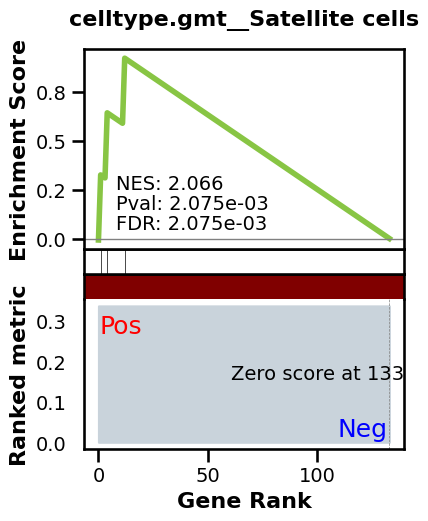

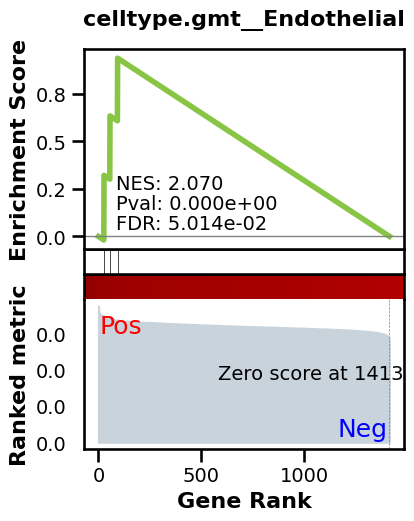

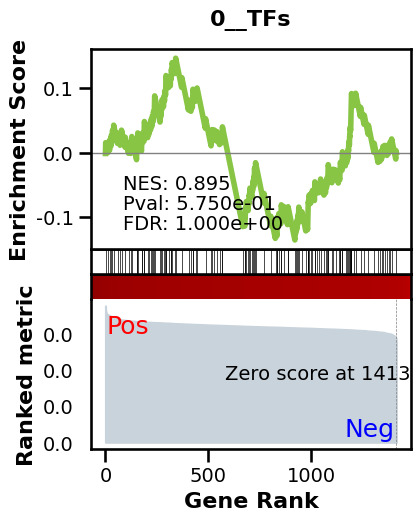

_________________________________________
TF specific enrichment


2024-05-24 14:07:22,678:INFO - Downloading and generating Enrichr library gene sets...
2024-05-24 14:07:22,680:INFO - Library is already downloaded in: /home/ml4ig1/.cache/gseapy/Enrichr.ENCODE_TF_ChIP-seq_2014.gmt, use local file
2024-05-24 14:07:22,866:INFO - 0332 gene_sets have been filtered out when max_size=2000 and min_size=0


found some significant results for  12.5 % TFs

_________________________________________
loading GT,  omnipath
intersection of 1000 genes
intersection pct: 0.7072135785007072
precision:  0.008232758620689656 
recall:  0.5332216638749302 
random precision: 0.0017927927927927929


100%|██████████| 99/99 [00:00<00:00, 505.46it/s]


Area Under Precision-Recall Curve (AUPRC):  0.009241347452318308
EPR: 11.635082182774491


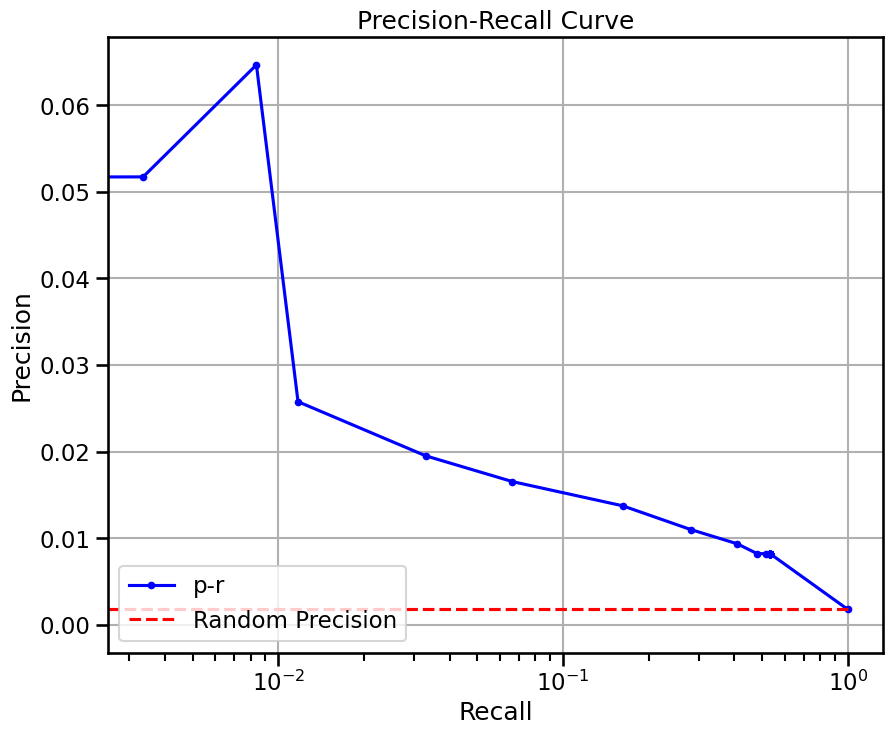

scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Log1p transforming ...
scGPT - INFO - Binning data ...


100%|██████████| 19/19 [00:04<00:00,  4.22it/s]


base enrichment
Top central genes: []


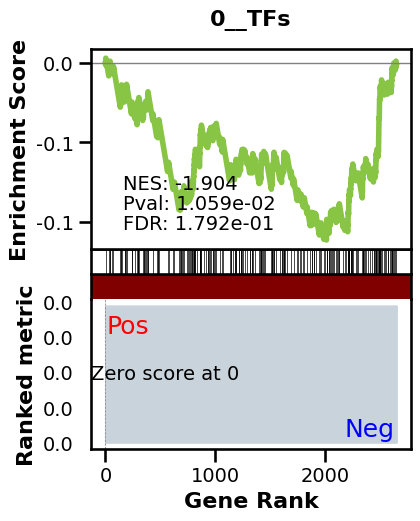

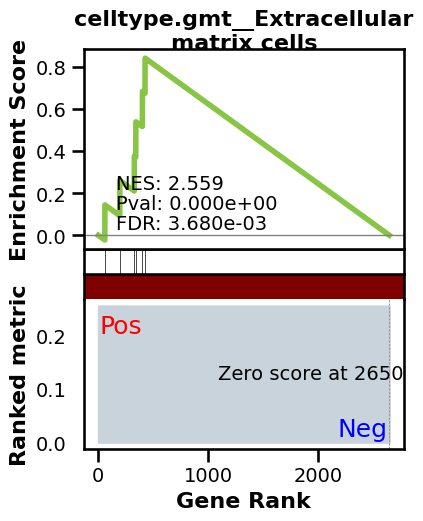

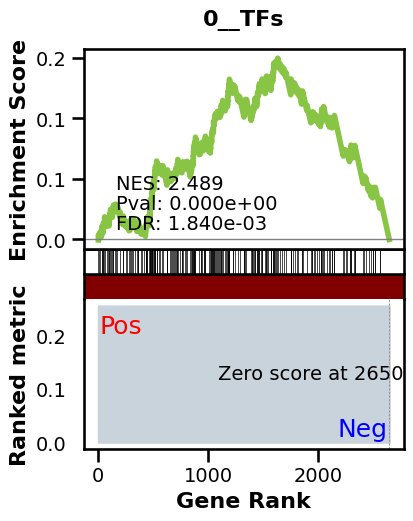

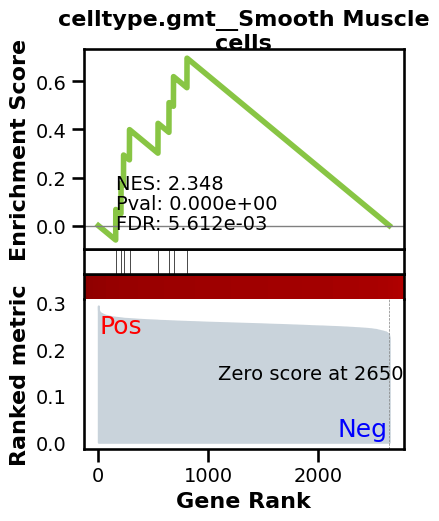

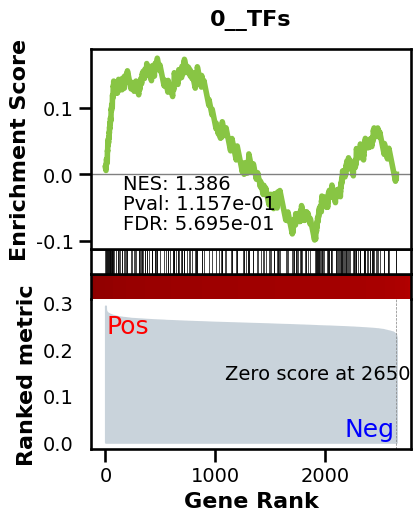

_________________________________________
TF specific enrichment


2024-05-24 14:07:54,281:INFO - Downloading and generating Enrichr library gene sets...
2024-05-24 14:07:54,283:INFO - Library is already downloaded in: /home/ml4ig1/.cache/gseapy/Enrichr.ENCODE_TF_ChIP-seq_2014.gmt, use local file
2024-05-24 14:07:54,471:INFO - 0332 gene_sets have been filtered out when max_size=2000 and min_size=0


found some significant results for  38.46153846153846 % TFs

_________________________________________
loading GT,  omnipath
intersection of 1974 genes
intersection pct: 0.7446246699358733
precision:  0.0017905004162522109 
recall:  1.0 
random precision: 0.0017914079177302911


100%|██████████| 99/99 [00:00<00:00, 156.64it/s]


Area Under Precision-Recall Curve (AUPRC):  0.002468575147573701
EPR: 3.9618793677562416


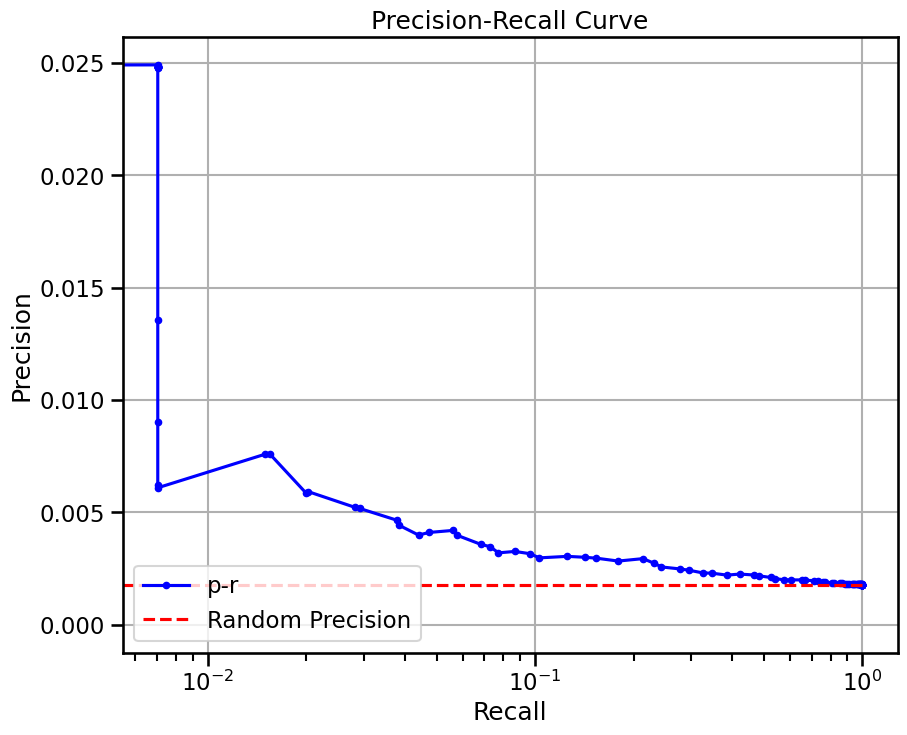

base enrichment
Top central genes: []


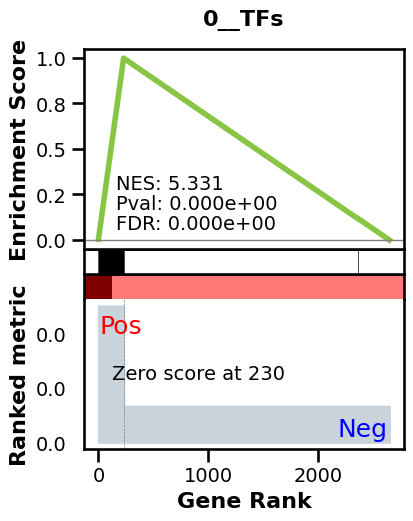

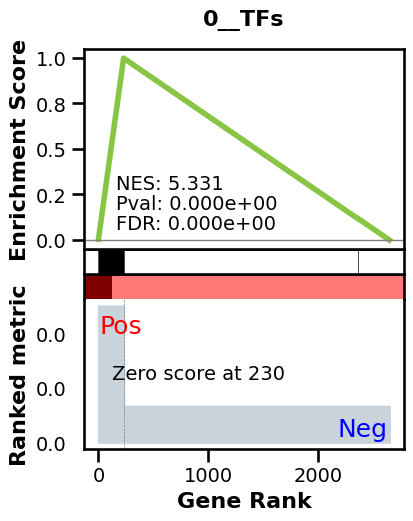

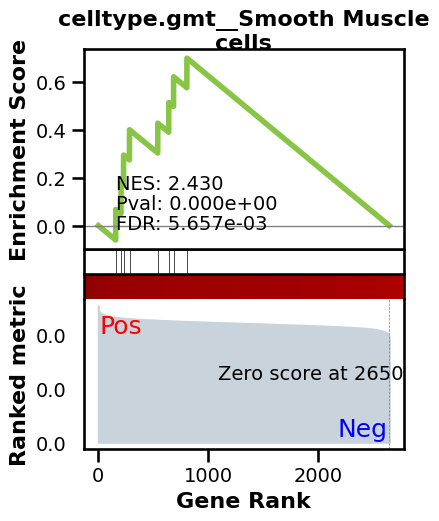

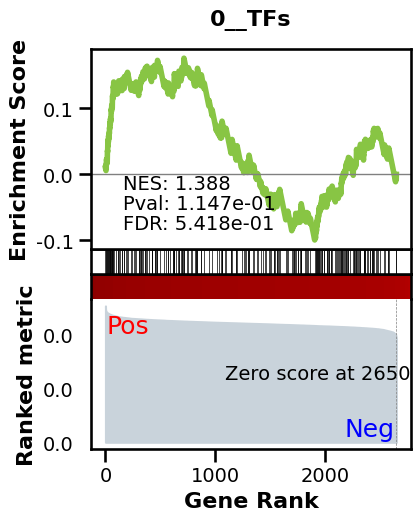

_________________________________________
TF specific enrichment


2024-05-24 14:08:23,085:INFO - Downloading and generating Enrichr library gene sets...
2024-05-24 14:08:23,087:INFO - Library is already downloaded in: /home/ml4ig1/.cache/gseapy/Enrichr.ENCODE_TF_ChIP-seq_2014.gmt, use local file
2024-05-24 14:08:23,290:INFO - 0332 gene_sets have been filtered out when max_size=2000 and min_size=0


found some significant results for  38.46153846153846 % TFs

_________________________________________
loading GT,  omnipath
intersection of 1974 genes
intersection pct: 0.7446246699358733
precision:  0.008686382690617842 
recall:  0.5185609860971765 
random precision: 0.0017914079177302911


100%|██████████| 99/99 [00:00<00:00, 157.42it/s]


Area Under Precision-Recall Curve (AUPRC):  0.008963420936191605
EPR: 12.229475185910065


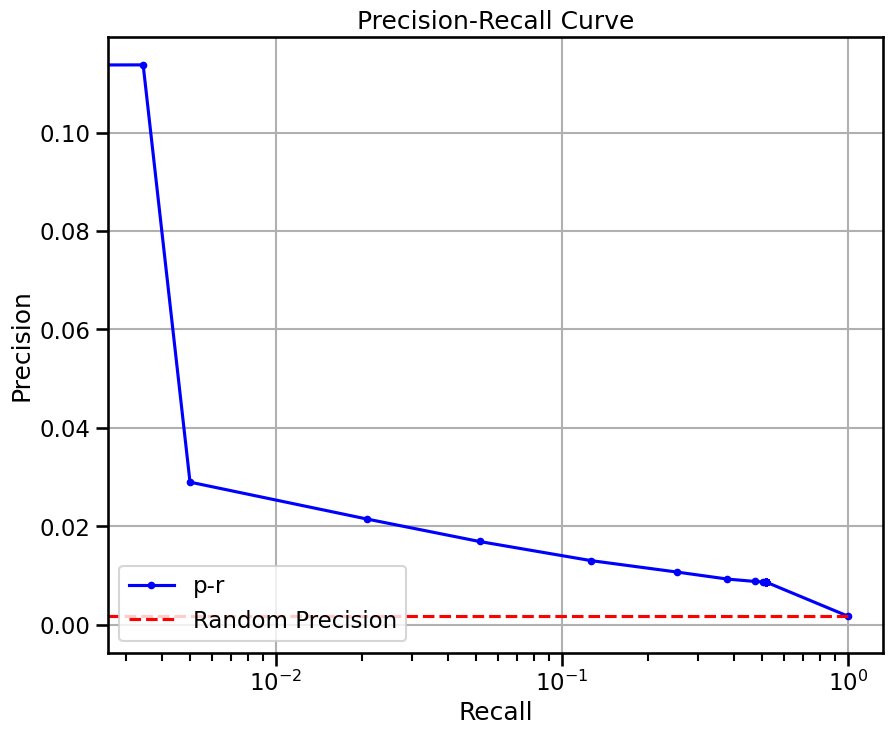

TypeError: __contains__(): incompatible function arguments. The following argument types are supported:
    1. (self: torchtext._torchtext.Vocab, arg0: str) -> bool

Invoked with: <torchtext._torchtext.Vocab object at 0x7effe65ad230>, nan

In [189]:
sc.tl.rank_genes_groups(
    adata, groupby="cell_type"
)
adata.var['ensembl_id'] = adata.var.index
metrics = {}
for celltype in CELLTYPES[3:]:
    to_use = adata.uns["rank_genes_groups"]["names"][celltype][
        : NUM_GENES
    ].tolist()
    subadata = adata[adata.obs.cell_type == celltype]
    subadata = subadata[subadata.X.sum(1) > 500][:1024, adata.var.index.isin(
        genes) & adata.var.index.isin(to_use)]
    subadata.var = subadata.var.set_index('feature_name')
    all_gene_ids, all_values, src_key_padding_mask, subadata = prepare_dataset(subadata)
    sum_attn_scores = generate_grn(model, all_gene_ids, all_values, src_key_padding_mask, batch_size = 10, num_attn_layers = 11)
    grn = GRNAnnData(subadata, grn=sum_attn_scores[1:,1:])
    metrics[celltype+'_scgpt'] = BenGRN(grn).scprint_benchmark()
    grn.varp['GRN'][~grn.var.isTF,:]=0
    metrics[celltype+'_scgpt'] = BenGRN(grn).scprint_benchmark()

In [190]:
metrics

{'blood vessel smooth muscle cell_scgpt': {'enriched_terms_Central': ['0__TFs',
   'celltype.gmt__Microfold cells',
   'celltype.gmt__Embryonic stem cells'],
  'TF_enr': True,
  'enriched_terms_Targets': ['celltype.gmt__Satellite cells'],
  'enriched_terms_Regulators': ['celltype.gmt__Smooth Muscle cells'],
  'significant_enriched_TFtargets': 27.083333333333332,
  'precision': 0.007374993499026298,
  'recall': 0.44651447564068925,
  'rand_precision': 0.0016385473238206916,
  'auprc': 0.006587314946516312,
  'EPR': 8.138513179625487},
 'podocyte_scgpt': {'enriched_terms_Central': ['0__TFs',
   'celltype.gmt__Enteric neurons',
   'celltype.gmt__Embryonic stem cells',
   'celltype.gmt__Microfold cells'],
  'TF_enr': True,
  'enriched_terms_Regulators': ['celltype.gmt__Endothelial cells'],
  'significant_enriched_TFtargets': 0.0,
  'precision': 0.00824524312896406,
  'recall': 0.4117599285308211,
  'rand_precision': 0.0015058568573783685,
  'auprc': 0.0066450517078790045,
  'EPR': 6.692030

In [192]:
celltype

'endothelial cell'

In [ ]:
sc.tl.rank_genes_groups(
    adata, groupby="cell_type"
)
adata.var['ensembl_id'] = adata.var.index
metrics = {}
for celltype in CELLTYPES[3:]:
    to_use = adata.uns["rank_genes_groups"]["names"][celltype][
        : NUM_GENES
    ].tolist()
    subadata = adata[adata.obs.cell_type == celltype]
    subadata = subadata[subadata.X.sum(1) > 500][:1024, adata.var.index.isin(
        genes) & adata.var.index.isin(to_use)]
    subadata.var = subadata.var.set_index('feature_name')
    all_gene_ids, all_values, src_key_padding_mask, subadata = prepare_dataset(subadata)
    sum_attn_scores = generate_grn(model, all_gene_ids, all_values, src_key_padding_mask, batch_size = 10, num_attn_layers = 11)
    grn = GRNAnnData(subadata, grn=sum_attn_scores[1:,1:])
    metrics[celltype+'_scgpt'] = BenGRN(grn).scprint_benchmark()
    grn.varp['GRN'][~grn.var.isTF,:]=0
    metrics[celltype+'_scgpt_TF'] = BenGRN(grn).scprint_benchmark()

## scGPT (gene embeddings)

In [ ]:
scgpt_emb

In [95]:
adata = sc.read('../save/scGPT_embeddings.h5ad')
scgpt_emb = from_embeddings(adata.T)
#ben.BenGRN(scgpt_emb, do_auc=True, doplot=True).compare_to(other=preadata)

KeyboardInterrupt: 